In [1]:
from IPython.display import display_html
display_html("""<button onclick="$('.input, .prompt, .output_stderr, .output_error').toggle();">Toggle Code</button>""", raw=True)

Toggle Code

# IEEE-CIS Fraud Detection

Fraud prevention system is protecting our daily transaction and actually saving consumers millions of dollars per year. However, the fraud detection system may be so "sensitive" that places us in an awkward situation. Just imagine standing at the check-out counter at a grocery store with a long line waiting for service and the cashier not-so-quietly announces that your card has been declined. And you step aside and allow the cashier to tend to the next customer. Then you receive a text message from your bank. “Press 1 if you really tried to spend $500 on nachos.”                 
In view of such cumbersome moment, this project is proposed and trying to improve the customer experience as well as fraud detection accuracy. The data comes from Vesta's real-world e-commerce transactions and contains a wide range of features from device type to product features. 

- **Goal**:         
improve the efficacy of fraudulent transaction

- **Data details**:          
The data is broken into two files identity and transaction, which are joined by TransactionID. Not all transactions have corresponding identity information.
    - Transaction table: 
        - TransactionID
        - TransactionDT: timedelta from a given reference datetime (not an actual timestamp)
        - TransactionAMT: transaction payment amount in USD
        - ProductCD: product code, the product for each transaction
        - card1 - card6: payment card information, such as card type, card category, issue bank, country, etc.
        - addr: address
        - dist: distance
        - P_ and (R__) emaildomain: purchaser and recipient email domain
        - C1-C14: counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is masked.
        - D1-D15: timedelta, such as days between previous transaction, etc.
        - M1-M9: match, such as names on card and address, etc.
    - Identity table:
        - TransactionID
        - id_01-id_38: identity information including network connection information (IP, ISP, Proxy, etc) and digital signature (UA/browser/os/version, etc) associated with transactions.
        - DeviceType
        - DeviceInfo 

# Import

In [2]:
import pandas as pd
import numpy as np
from scipy import stats
import gc
pd.set_option('display.max_columns', None)

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('classic')
sns.set_palette('deep')
sns.set_style('white')
%matplotlib inline

In [4]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

# Load Data and Overview

In [5]:
train_identity = pd.read_csv('./Data/train_identity.csv')
train_trans = pd.read_csv('./Data/train_transaction.csv')
test_identity = pd.read_csv('./Data/test_identity.csv')
test_trans = pd.read_csv('./Data/test_transaction.csv')

## Check TransactionID in identity and transaction  

In [6]:
print('Train')
print('Number of TransactionID is train_identity: ', train_identity.shape[0])
print('Number of TransactionID is train_transaction: ', train_trans.shape[0])
print('Number of TransactionID in train have an associated train_identity: ', 
      train_trans.TransactionID.isin(train_identity.TransactionID).sum())
print('Ratio of TransactionID in train have an associated train_identity: {:.2f}%'.format(
    train_trans.TransactionID.isin(train_identity.TransactionID).mean()*100))
print('Test')
print('Number of TransactionID is test_identity: ', test_identity.shape[0])
print('Number of TransactionID is test_transaction: ', test_trans.shape[0])
print('Number of TransactionID in test have an associated test_identity: ', 
      test_trans.TransactionID.isin(test_identity.TransactionID).sum())
print('Ratio of TransactionID in test have an associated test_identity: {:.2f}%'.format(
    test_trans.TransactionID.isin(test_identity.TransactionID).mean()*100))

Train
Number of TransactionID is train_identity:  144233
Number of TransactionID is train_transaction:  590540
Number of TransactionID in train have an associated train_identity:  144233
Ratio of TransactionID in train have an associated train_identity: 24.42%
Test
Number of TransactionID is test_identity:  141907
Number of TransactionID is test_transaction:  506691
Number of TransactionID in test have an associated test_identity:  141907
Ratio of TransactionID in test have an associated test_identity: 28.01%


In [7]:
train = pd.merge(train_trans, train_identity, on='TransactionID', how='left')
test = pd.merge(test_trans, test_identity, on='TransactionID', how='left')

In [8]:
train = reduce_mem_usage(train)

Memory usage of dataframe is 1959.88 MB
Memory usage after optimization is: 530.08 MB
Decreased by 73.0%


In [9]:
test = reduce_mem_usage(test)

Memory usage of dataframe is 1677.73 MB
Memory usage after optimization is: 462.08 MB
Decreased by 72.5%


In [10]:
%%capture
col_name = test.columns.tolist()
col_name.insert(col_name.index('TransactionDT'),'isFraud')
test.reindex(columns=col_name)

In [11]:
train['is_train'] = 1
test['is_train'] = 0
test['isFraud'] = 99

In [12]:
df = pd.concat([train, test], ignore_index=True, sort=False)

In [13]:
del train_identity, train_trans, test_identity, test_trans; gc.collect()

62

## Data overview

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1097231 entries, 0 to 1097230
Columns: 436 entries, Unnamed: 0 to is_train
dtypes: float64(399), int64(6), object(31)
memory usage: 3.6+ GB


In [15]:
df.head()

TransactionID isFraud  TransactionDT  TransactionAmt ProductCD  card1  \
0        2987000       0          86400            68.5         W  13926   
1        2987001       0          86401            29.0         W   2755   
2        2987002       0          86469            59.0         W   4663   
3        2987003       0          86499            50.0         W  18132   
4        2987004       0          86506            50.0         H   4497   

   card2  card3       card4  card5   card6  addr1  addr2  dist1  dist2  \
0    NaN  150.0    discover  142.0  credit  315.0   87.0   19.0    NaN   
1  404.0  150.0  mastercard  102.0  credit  325.0   87.0    NaN    NaN   
2  490.0  150.0        visa  166.0   debit  330.0   87.0  287.0    NaN   
3  567.0  150.0  mastercard  117.0   debit  476.0   87.0    NaN    NaN   
4  514.0  150.0  mastercard  102.0  credit  420.0   87.0    NaN    NaN   

  P_emaildomain R_emaildomain   C1   C2   C3   C4   C5   C6   C7   C8   C9  \
0           NaN           NaN  1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0   
1     gmail.com           NaN  1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0   
2   outlook.com           NaN  1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0   
3     yahoo.com           NaN  2.0  5.0  0.0  0.0  0.0  4.0  0.0  0.0  1.0   
4     gmail.com           NaN  1.0  1.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0   

   C10  C11  C12   C13  C14     D1     D2    D3    D4   D5  D6  D7  D8  D9  \
0  0.0  2.0  0.0   1.0  1.0   14.0    NaN  13.0   NaN  NaN NaN NaN NaN NaN   
1  0.0  1.0  0.0   1.0  1.0    0.0    NaN   NaN   0.0  NaN NaN NaN NaN NaN   
2  0.0  1.0  0.0   1.0  1.0    0.0    NaN   NaN   0.0  NaN NaN NaN NaN NaN   
3  0.0  1.0  0.0  25.0  1.0  112.0  112.0   0.0  94.0  0.0 NaN NaN NaN NaN   
4  1.0  1.0  0.0   1.0  1.0    0.0    NaN   NaN   NaN  NaN NaN NaN NaN NaN   

    D10    D11  D12  D13  D14    D15   M1   M2   M3   M4   M5   M6   M7   M8  \
0  13.0   13.0  NaN  NaN  NaN    0.0    T    T    T   M2    F    T  NaN  NaN   
1   0.0    NaN  NaN  NaN  NaN    0.0  NaN  NaN  NaN   M0    T    T  NaN  NaN   
2   0.0  315.0  NaN  NaN  NaN  315.0    T    T    T   M0    F    F    F    F   
3  84.0    NaN  NaN  NaN  NaN  111.0  NaN  NaN  NaN   M0    T    F  NaN  NaN   
4   NaN    NaN  NaN  NaN  NaN    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

    M9   V1   V2   V3   V4   V5   V6   V7   V8   V9  V10  V11  V12  V13  V14  \
0  NaN  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0   
1  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  0.0  0.0  1.0   
2    F  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0   
3  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  1.0  1.0  1.0   
4  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

   V15  V16  V17  V18  V19  V20  V21  V22  V23  V24  V25  V26  V27  V28  V29  \
0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0   
2  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0   
3  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0   
4  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

   V30  V31  V32  V33  V34  V35  V36  V37  V38  V39  V40  V41  V42  V43  V44  \
0  0.0  0.0  0.0  0.0  0.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  0.0  0.0  1.0   
2  0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  0.0  0.0  1.0   
3  0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  0.0  0.0  1.0   
4  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

   V45  V46  V47  V48  V49  V50  V51  V52  V53  V54  V55  V56  V57  V58  V59  \
0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  1.0  1.0  1.0  1.0  0.0  0.0  0.0   
1  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  0.0   

## Check missing data

In [16]:
train.isna().apply(lambda x: x.value_counts(), axis=0)

Unnamed: 0  TransactionID   isFraud  TransactionDT  TransactionAmt  \
False    590540.0       590540.0  590540.0       590540.0        590540.0   
True          NaN            NaN       NaN            NaN             NaN   

       ProductCD     card1   card2   card3   card4   card5   card6   addr1  \
False   590540.0  590540.0  581607  588975  588963  586281  588969  524834   
True         NaN       NaN    8933    1565    1577    4259    1571   65706   

        addr2   dist1   dist2  P_emaildomain  R_emaildomain        C1  \
False  524834  238269   37627         496084         137291  590540.0   
True    65706  352271  552913          94456         453249       NaN   

             C2        C3        C4        C5        C6        C7        C8  \
False  590540.0  590540.0  590540.0  590540.0  590540.0  590540.0  590540.0   
True        NaN       NaN       NaN       NaN       NaN       NaN       NaN   

             C9       C10       C11       C12       C13       C14      D1  \
False  590540.0  590540.0  590540.0  590540.0  590540.0  590540.0  589271   
True        NaN       NaN       NaN       NaN       NaN       NaN    1269   

           D2      D3      D4      D5      D6      D7      D8      D9     D10  \
False  309743  327662  421618  280699   73187   38917   74926   74926  514518   
True   280797  262878  168922  309841  517353  551623  515614  515614   76022   

          D11     D12     D13     D14     D15        M1        M2        M3  \
False  311253   64717   61952   62187  501427  590540.0  590540.0  590540.0   
True   279287  525823  528588  528353   89113       NaN       NaN       NaN   

             M4        M5        M6        M7        M8        M9      V1  \
False  590540.0  590540.0  590540.0  590540.0  590540.0  590540.0  311253   
True        NaN       NaN       NaN       NaN       NaN       NaN  279287   

           V2      V3      V4      V5      V6      V7      V8      V9     V10  \
False  311253  311253  311253  311253  311253  311253  311253  311253  311253   
True   279287  279287  279287  279287  279287  279287  279287  279287  279287   

          V11     V12     V13     V14     V15     V16     V17     V18     V19  \
False  311253  514467  514467  514467  514467  514467  514467  514467  514467   
True   279287   76073   76073   76073   76073   76073   76073   76073   76073   

          V20     V21     V22     V23     V24     V25     V26     V27     V28  \
False  514467  514467  514467  514467  514467  514467  514467  514467  514467   
True    76073   76073   76073   76073   76073   76073   76073   76073   76073   

          V29     V30     V31     V32     V33     V34     V35     V36     V37  \
False  514467  514467  514467  514467  514467  514467  421571  421571  421571   
True    76073   76073   76073   76073   76073   76073  168969  168969  168969   

          V38     V39     V40     V41     V42     V43     V44     V45     V46  \
False  421571  421571  421571  421571  421571  421571  421571  421571  421571   
True   168969  168969  168969  168969  168969  168969  168969  168969  168969   

          V47     V48     V49     V50     V51     V52     V53     V54     V55  \
False  421571  421571  421571  421571  421571  421571  513444  513444  513444   
True   168969  168969  168969  168969  168969  168969   77096   77096   77096   

          V56     V57     V58     V59     V60     V61     V62     V63     V64  \
False  513444  513444  513444  513444  513444  513444  513444  513444  513444   
True    77096   77096   77096   77096   77096   77096   77096   77096   77096   

          V65     V66     V67     V68     V69     V70     V71     V72     V73  \
False  513444  513444  513444  513444  513444  513444  513444  513444  513444   
True    77096   77096   77096   77096   77096   77096   77096   77096   77096   

          V74     V75     V76     V77     V78     V79     V80     V81     V82  \
False  513444  501376  501376  501376  501376  501376  501376  501376  501376   
True    77096   89164 

In [17]:
test.isna().apply(lambda x: x.value_counts(), axis=0)

Unnamed: 0  TransactionID   isFraud  TransactionDT  TransactionAmt  \
False    506691.0       506691.0  506691.0       506691.0        506691.0   
True          NaN            NaN       NaN            NaN             NaN   

       ProductCD     card1   card2   card3   card4   card5   card6   addr1  \
False   506691.0  506691.0  498037  503689  503605  502144  503684  441082   
True         NaN       NaN    8654    3002    3086    4547    3007   65609   

        addr2   dist1   dist2  P_emaildomain  R_emaildomain      C1      C2  \
False  441082  215474   36436         437499         135870  506688  506688   
True    65609  291217  470255          69192         370821       3       3   

           C3      C4      C5      C6      C7      C8      C9     C10     C11  \
False  506688  506688  506688  506688  506688  506688  506688  506688  506688   
True        3       3       3       3       3       3       3       3       3   

          C12     C13     C14      D1      D2      D3      D4      D5      D6  \
False  506688  501943  506688  500660  271922  303549  429840  282316  124783   
True        3    4748       3    6031  234769  203142   76851  224375  381908   

           D7      D8      D9     D10     D11     D12     D13     D14     D15  \
False   60133   74338   74338  494146  330173   69254  123384  115194  494622   
True   446558  432353  432353   12545  176518  437437  383307  391497   12069   

           M1      M2      M3      M4      M5      M6      M7      M8      M9  \
False  330052  330052  330052  268946  197059  347752  271673  271687  271687   
True   176639  176639  176639  237745  309632  158939  235018  235004  235004   

           V1      V2      V3      V4      V5      V6      V7      V8      V9  \
False  330173  330173  330173  330173  330173  330173  330173  330173  330173   
True   176518  176518  176518  176518  176518  176518  176518  176518  176518   

          V10     V11     V12     V13     V14     V15     V16     V17     V18  \
False  330173  330173  494102  494102  494102  494102  494102  494102  494102   
True   176518  176518   12589   12589   12589   12589   12589   12589   12589   

          V19     V20     V21     V22     V23     V24     V25     V26     V27  \
False  494102  494102  494102  494102  494102  494102  494102  494102  494102   
True    12589   12589   12589   12589   12589   12589   12589   12589   12589   

          V28     V29     V30     V31     V32     V33     V34     V35     V36  \
False  494102  494102  494102  494102  494102  494102  494102  429837  429837   
True    12589   12589   12589   12589   12589   12589   12589   76854   76854   

          V37     V38     V39     V40     V41     V42     V43     V44     V45  \
False  429837  429837  429837  429837  429837  429837  429837  429837  429837   
True    76854   76854   76854   76854   76854   76854   76854   76854   76854   

          V46     V47     V48     V49     V50     V51     V52     V53     V54  \
False  429837  429837  429837  429837  429837  429837  429837  493792  493792   
True    76854   76854   76854   76854   76854   76854   76854   12899   12899   

          V55     V56     V57     V58     V59     V60     V61     V62     V63  \
False  493792  493792  493792  493792  493792  493792  493792  493792  493792   
True    12899   12899   12899   12899   12899   12899   12899   12899   12899   

          V64     V65     V66     V67     V68     V69     V70     V71     V72  \
False  493792  493792  493792  493792  493792  493792  493792  493792  493792   
True    12899   12899   12899   12899   12899   12899   12899   12899   12899   

          V73     V74     V75     V76     V77     V78     V79     V80     V81  \
False  493792  493792  494610  494610  494610  494610  494610  494610  494610   
True    12899   12899   12081   12081   12081   12081   12081   12081   12081   

          V82     V83     V84     V85     V86     V87     V88     V89     V90  \
False  494610  494610  494610  494610  494610  49

In [18]:
print('Missing columns in train: ', train.isnull().any().sum())
print('Missing columns in test: ', test.isnull().any().sum())

Missing columns in train:  414
Missing columns in test:  385


Most of the columns in train and test have missing records. Need to deal with carefully.

## Features

Most of the features in our data are continuous. And the categorical Features are as follows:
- ProductCD
- card1 - card6
- addr1, addr2
- Pemaildomain 
- Remaildomain
- M1 - M9
- DeviceType
- DeviceInfo
- id12 - id38

# Exploratory Data Analysis

## Define Functions

In [19]:
def resumetable(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values    
    summary['Uniques'] = df.nunique().values
    summary['First Value'] = df.loc[0].values
    summary['Second Value'] = df.loc[1].values
    summary['Third Value'] = df.loc[2].values

    for name in summary['Name'].value_counts().index:
        summary.loc[summary['Name'] == name, 'Entropy'] = round(stats.entropy(df[name].value_counts(normalize=True), base=2),2) 

    return summary

In [20]:
def FraudRatio(col):
    res = pd.crosstab(train[col], train['isFraud'], normalize='index') * 100
    res = res.reset_index()
    res.rename(columns={0:'Not Fraud', 1:'Fraud'}, inplace=True)
    return res

In [21]:
def groupby_cnt_ratio(df, col):
    if isinstance(col, str):
        col = [col]
    key = ['is_train', 'isFraud'] + col
    cnt_stat = df.groupby(key).size().to_frame('count')
    ratio_stat = (cnt_stat / cnt_stat.groupby(['is_train', 'isFraud']).sum()).rename(columns={'count':'count_ratio'})
    return pd.merge(cnt_stat, ratio_stat, on=key, how='outer')

In [22]:
def CalcOutliers(df_num): 

    data_mean, data_std = np.mean(df_num), np.std(df_num)
    cut = data_std * 3

    lower, upper = data_mean - cut, data_mean + cut
    outliers_lower = [x for x in df_num if x < lower]
    outliers_higher = [x for x in df_num if x > upper]
    outliers_total = [x for x in df_num if x < lower or x > upper]

    outliers_removed = [x for x in df_num if x > lower and x < upper]
    
    print('Identified lowest outliers: %d' % len(outliers_lower)) # printing total number of values in lower cut of outliers
    print('Identified upper outliers: %d' % len(outliers_higher)) # printing total number of values in higher cut of outliers
    print('Total outlier observations: %d' % len(outliers_total)) # printing total number of values outliers of both sides
    print('Non-outlier observations: %d' % len(outliers_removed)) # printing total number of non outlier values
    print("Total percentual of Outliers: ", round((len(outliers_total) / len(outliers_removed) )*100, 4)) # Percentual of outliers in points
    
    return

In [23]:
def text_style_func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%({:d})".format(pct, absolute)

def pie_param(ax, df, col, color_palette):
    return ax.pie(df['count_ratio'].values, autopct=lambda pct: text_style_func(pct, df['count']), 
                  labels=df[col], explode=[0.2]+ np.zeros(len(df)-1).tolist(), pctdistance=0.5, 
                  startangle = 90, labeldistance = 1, colors=sns.color_palette(color_palette, 7))

In [24]:
def pie_chart(col, ylabel):
    plt.style.use('seaborn-poster')
    col_cnt = groupby_cnt_ratio(df, col).reset_index()
    col_cnt_train = col_cnt[col_cnt['is_train'] == 1]
    col_cnt_train_fraud = col_cnt_train[col_cnt_train['isFraud'] == 1]
    col_cnt_train_not_fraud = col_cnt_train[col_cnt_train['isFraud'] == 0]
    col_cnt_test = col_cnt[col_cnt['is_train'] == 0]
    plt.style.use('seaborn-poster')
    sns.set_palette('deep')
    fig, ax = plt.subplots(1, 3, figsize=(16,9))
    ax[0].set_title('train: fraud', fontsize=16)
    ax[0].set(ylabel=str(ylabel)+' ratio')
    pie_param(ax[0], col_cnt_train_fraud, col, "coolwarm")
    ax[1].set_title('train: not fraud',  fontsize=16)
    pie_param(ax[1], col_cnt_train_not_fraud, col, "coolwarm")
    ax[2].set_title('test',  fontsize=16)
    pie_param(ax[2], col_cnt_test, col, "coolwarm")

In [25]:
def card_num_plot(col, is_hist, limit):
    plt.style.use('classic')
    sns.set_palette('deep')
    sns.set_style('white')
    count_data = train.loc[train[col].isin(
            train[col].value_counts()[train[col].value_counts() > limit].index)]
    data = FraudRatio(col).loc[FraudRatio(col)[col].isin(
            train[col].value_counts()[train[col].value_counts() > limit].index)]
    plt.figure(figsize=(12,3))
    if is_hist == 1:
        sns.distplot(train[train['isFraud'] == 1][col].dropna(), label='Fraud')
        sns.distplot(train[train['isFraud'] == 0][col].dropna(), 
                     label='not Fraud').set_title(str(col)+': Distribution', fontsize=22)
        plt.legend()
    else:
        g = sns.countplot(x=col, data=count_data.dropna(), order=list(data[col].values))
        gt = g.twinx()
        gt = sns.pointplot(x=col, y='Fraud', data=data.dropna(), color='black', legend=False, order=list(data[col].values))
        g.set_title(str(col)+': Distribution and % of Fraud', fontsize=22)
        gt.set_ylabel("% of Fraud Transactions")
        g.set_xlabel("")
        g.set_xticklabels(g.get_xticklabels(), rotation=90)
        
        for p in g.patches:
            height = p.get_height()
            g.text(p.get_x()+p.get_width()/2., 
                   height + 3, '{:1.2f}%'.format(height/len(train)*100), 
                   ha="center",fontsize=8)

In [26]:
def cat_plot_set(col, chart):
    data = FraudRatio(col)
    
    plt.style.use('classic')
    sns.set_palette('deep')
    sns.set_style('white')
    plt.tight_layout()
    plt.figure(figsize=(12,9))
    plt.suptitle(str(col)+' Distributions', fontsize=22)

    plt.subplot(211)
    plt.imshow(chart)
    plt.axis('off')

    plt.subplot(223)
    g1 = sns.countplot(x=col, data=train, hue='isFraud', order=list(data[col].values))
    gt = g1.twinx()
    gt = sns.pointplot(x=col, y='Fraud', data=data, color='black', legend=False, order=list(data[col].values))
    g1.set_title(str(col)+' Distribution and % of Fraud', fontsize=16)
    gt.set_ylabel("% of Fraud Transactions")

    plt.subplot(224)
    g2 = sns.boxenplot(x=col, y='TransactionAmt', hue='isFraud', 
                  data=train[train['TransactionAmt'] <= 2000], order=list(data[col].values))
    g2.set_title("Transaction Amount Distribuition", fontsize=16)
    g2.yaxis.tick_right()
    g2.yaxis.set_label_position("right")

    plt.subplots_adjust(hspace = 0.15, top = 0.95)

In [27]:
def barh_plot_isFraud(col, size, n, limit): 
    fig, axes = plt.subplots(1, 2, figsize=size)
    ax1 = plt.subplot2grid((1, 2), (0, 0), colspan=1)
    ax2 = plt.subplot2grid((1, 2), (0, 1), colspan=1)

    train[train['isFraud'] == 1][col].value_counts().sort_values().tail(n).plot(
        kind='barh', color=sns.color_palette("coolwarm"), ax=ax1)
    train[train['isFraud'] == 0][col].value_counts().sort_values().tail(n).plot(
        kind='barh', color=sns.color_palette("coolwarm"), ax=ax2)

    ax1.set_title('Fraud', fontsize=16)
    ax2.set_title('Not Fraud', fontsize=16)
    ax2.yaxis.tick_right()

In [28]:
def percent_hist_set(col, size, n, limit, is_hist):
    plt.suptitle(str(col)+' Distributions', fontsize=22)
    card_num_plot(col, is_hist, limit)
    plt.show()
    barh_plot_isFraud(col, size, n, limit)

In [29]:
def percent_box_set(col, limit, is_hist):
    plt.figure(figsize=(12,3))
    plt.suptitle(str(col)+' Distributions', fontsize=22)  
    count_data = train.loc[train[col].isin(
        train[col].value_counts()[train[col].value_counts() > limit].index)]
    data = FraudRatio(col).loc[FraudRatio(col)[col].isin(
            train[col].value_counts()[train[col].value_counts() > limit].index)]
    
    plt.subplot(121)
    g = sns.countplot(x=col, data=count_data, order=list(data[col].values))
    gt = g.twinx()
    gt = sns.pointplot(x=col, y='Fraud', data=data, color='black', legend=False, order=list(data[col].values))
    g.set_title(str(col)+': Distribution and % of Fraud', fontsize=16)
    gt.set_ylabel("% of Fraud Transactions")
    g.set_xlabel("")
    g.set_xticklabels(g.get_xticklabels(), rotation=90)

    for p in g.patches:
        height = p.get_height()
        g.text(p.get_x()+p.get_width()/2., 
               height + 3, '{:1.2f}%'.format(height/len(train)*100), 
               ha="center",fontsize=8)
        
    plt.subplot(122)
    g1 = sns.boxenplot(x=col, y='TransactionAmt', hue='isFraud', 
                  data=train[train['TransactionAmt'] <= 2000], order=list(data[col].values))
    g1.set_title("Transaction Amount Distribuition", fontsize=16)
    g1.yaxis.tick_right()
    g1.yaxis.set_label_position("right")
    
    plt.subplots_adjust(hspace=.4, wspace = 0.35, top = 0.80)

In [30]:
def card_num_plot_isFraud(col, is_hist, limit):
    plt.style.use('classic')
    sns.set_palette('deep')
    sns.set_style('white')
    count_data = train.loc[train[col].isin(
            train[col].value_counts()[train[col].value_counts() > limit].index)]
    data = FraudRatio(col).loc[FraudRatio(col)[col].isin(
            train[col].value_counts()[train[col].value_counts() > limit].index)]
    plt.figure(figsize=(12,3))

    g = sns.countplot(x=col, data=count_data, hue='isFraud', order=list(data[col].values))
    gt = g.twinx()
    gt = sns.pointplot(x=col, y='Fraud', data=data, color='black', legend=False, order=list(data[col].values))
    g.set_title(str(col)+': Distribution and % of Fraud', fontsize=22)
    gt.set_ylabel("% of Fraud Transactions")
    g.set_xlabel("")
    g.set_xticklabels(g.get_xticklabels(), rotation=90)

## Overall Checking
### -- Train and test

In [31]:
train_count = len(train)
print('Size of train data',train_count)
test_count = len(test)
print('Size of test data',test_count)
print('Ratio of train to test：', train_count/test_count)

Size of train data 590540
Size of test data 506691
Ratio of train to test： 1.1654834998056014


Train and test have similar size.

### -- isFraud

Text(0.5, 1.0, 'Distribution of isFraud')

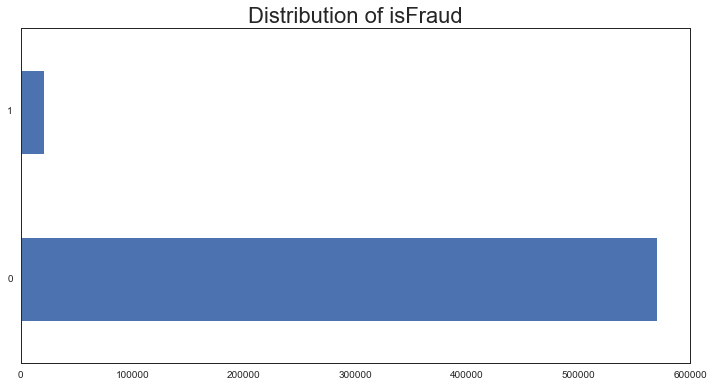

In [32]:
plt.figure(figsize=(12,6))
train['isFraud'].value_counts().plot(kind='barh')
plt.title('Distribution of isFraud', fontsize=22)

In [33]:
print('Number of fraud transaction in train: ', sum(train['isFraud'] == 1))
print('Number of not fraud transaction in train: ', sum(train['isFraud'] == 0))
print('Ratio of fraud transaction in train: {:.2f}%'.format(sum(train['isFraud'] == 1)/sum(train['isFraud'] == 0)*100))

Number of fraud transaction in train:  20663
Number of not fraud transaction in train:  569877
Ratio of fraud transaction in train: 3.63%


Our data is unbalanced which is typical in the binary classification problems. Only 3.63% transactions are fraud.

## Card features
- Features: card1 - card6
- All features are categorical. 

In [34]:
resumetable(df[['card1', 'card2', 'card3','card4', 'card5', 'card6']])

Dataset Shape: (1097231, 6)


Name    dtypes  Missing  Uniques First Value Second Value Third Value  \
0  card1     int16        0    17091       13926         2755        4663   
1  card2   float16    17587      501         NaN          404         490   
2  card3   float16     4567      133         150          150         150   
3  card4  category     4663        4    discover   mastercard        visa   
4  card5   float16     8806      138         142          102         166   
5  card6    object     4578        4      credit       credit       debit   

   Entropy  
0    10.01  
1     6.32  
2     0.74  
3     1.07  
4     2.66  
5     0.80

- card4 and card6 seem to be string and rest 4 are numericals.
- Except for card1, rest 5 have many missing values.

###  Categoricals: card4 and card6 
### --  card4: card company

In [35]:
groupby_cnt_ratio(df, 'card4')

count  count_ratio
is_train isFraud card4                                
0        99      american express    7681     0.015252
                 discover            2873     0.005705
                 mastercard        158169     0.314074
                 visa              334882     0.664970
1        0       american express    8089     0.014233
                 discover            6137     0.010798
                 mastercard        182721     0.321499
                 visa              371394     0.653470
         1       american express     239     0.011590
                 discover             514     0.024925
                 mastercard          6496     0.315003
                 visa               13373     0.648482

In [36]:
%%capture
pie_chart('card4', 'card company')

In [37]:
import matplotlib.image as mpimg
pie_card4 = mpimg.imread('./Fig/Card_company.png')

<Figure size 640x480 with 0 Axes>

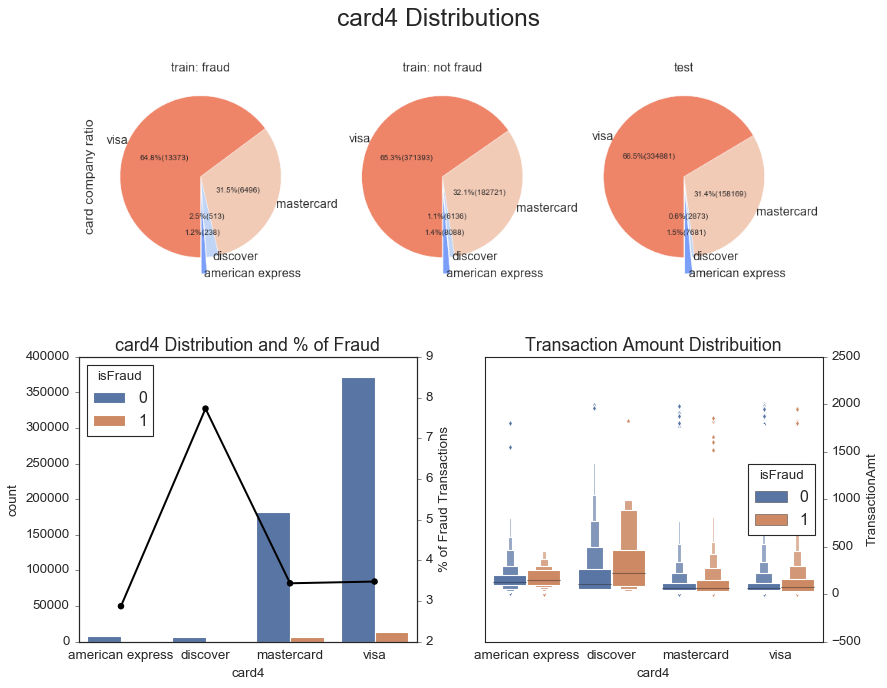

In [38]:
cat_plot_set('card4', pie_card4)

- For both train and test data, nearly 95% of transactions made through visa and mastercards.
- Distributions show little difference. But if we dig into the numbers, we'll get another story. Although its total number of fraudulent transactions are still the lowest in fraud records, the ratio of discover is more than double in fradulent transactions. While ratios for other card companies are lower than the not fraudulent records.
- And after normalization, the ratio of Discover runs highest(~8%) in fraud transactions while (~3%) for visa, mastercard and american express.
- Cards of Discover may be at a higher risk of fraud transaction.

### -- card6: charge, debit or credit

In [39]:
groupby_cnt_ratio(df, 'card6')

count  count_ratio
is_train isFraud card6                               
0        99      charge card           1     0.000002
                 credit           118662     0.235588
                 debit            385021     0.764410
1        0       charge card          15     0.000026
                 credit           139036     0.244633
                 debit            429264     0.755288
                 debit or credit      30     0.000053
         1       credit             9950     0.482448
                 debit             10674     0.517552

In [40]:
%%capture
pie_chart('card6', 'card type')

In [41]:
import matplotlib.image as mpimg
pie_card6 = mpimg.imread('./Fig/Card_type.png')

<Figure size 640x480 with 0 Axes>

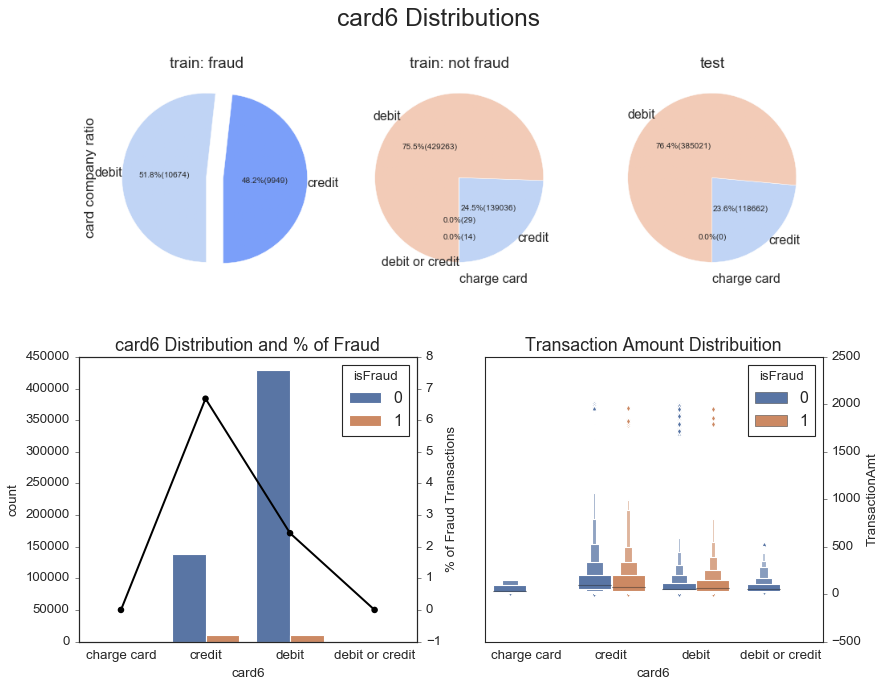

In [42]:
cat_plot_set('card6', pie_card6)

- Debit card accounts for around 75% in not fraud data and test data.
- Credit card seems to be the main source of fraud transaction. The percentage of transactions using credit card is doubled in fradulent records comparing with not fraud. And its fraud ratio is much higher than others.

###  Numericals: card1--card3 and card5
- Although card3 and card5 are represented in numericals, they seem to be categorical in fact. 

In [43]:
df.groupby('is_train')[['card3','card5']].agg(['max','min', 'mean','median', 'std'])

card3                                       card5         \
            max    min        mean median        std    max    min   
is_train                                                             
0         232.0  100.0  153.543409  150.0  12.443013  237.0  100.0   
1         231.0  100.0  153.194925  150.0  11.336444  237.0  100.0   

                                        
                mean median        std  
is_train                                
0         200.162975  226.0  40.562461  
1         199.278897  226.0  41.244453

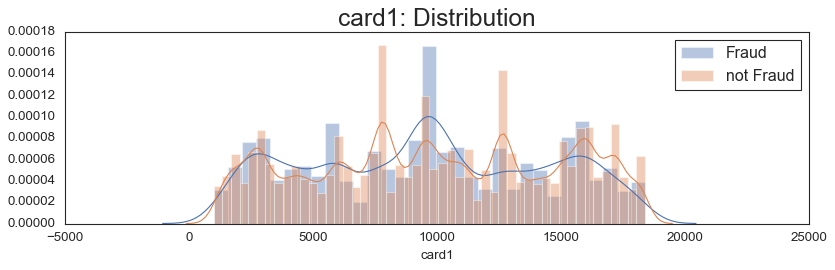

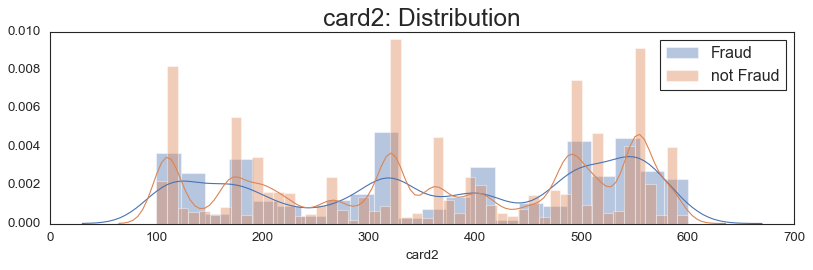

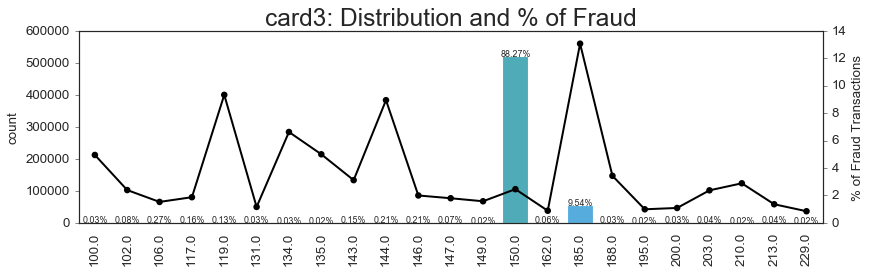

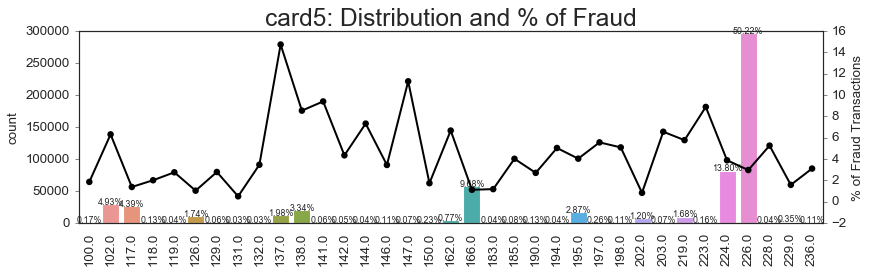

In [44]:
for col, is_hist, limit in [['card1', 1, None], ['card2', 1, None], ['card3', 0, 100], ['card5', 0, 200]]:
    card_num_plot(col, is_hist, limit)

## Product feature: ProductCD

In [45]:
groupby_cnt_ratio(df, 'ProductCD')

count  count_ratio
is_train isFraud ProductCD                     
0                C           69266     0.136703
                 H           29373     0.057970
                 R           35647     0.070353
                 S           11418     0.022534
                 W          360987     0.712440
1        0       C           60511     0.106183
                 H           31450     0.055187
                 R           36273     0.063651
                 S           10942     0.019201
                 W          430701     0.755779
         1       C            8008     0.387553
                 H            1574     0.076175
                 R            1426     0.069012
                 S             686     0.033199
                 W            8969     0.434061

In [46]:
%%capture
pie_chart('ProductCD', 'Product code')

In [47]:
import matplotlib.image as mpimg
pie_prod = mpimg.imread('./Fig/Product_code.png')

<Figure size 640x480 with 0 Axes>

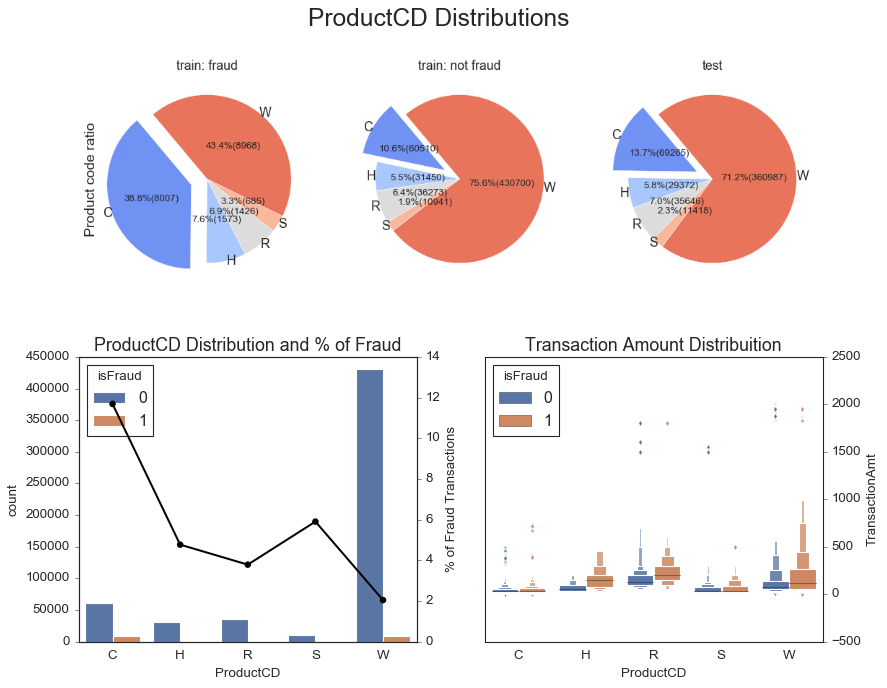

In [48]:
cat_plot_set('ProductCD', pie_prod)

 - Products with code C are closely associated with fraudulent transactions.

## Transaction features
- TransactionAMT
- addr
- dist
- P_ and (R__) emaildomain
- C1-C14
- M1-M9

### -- TransactionAmt

In [49]:
df.groupby('is_train')['TransactionAmt'].agg(['max','min', 'mean','median', 'std'])

max    min        mean  median         std
is_train                                                  
0         10270.000  0.018  134.725568  67.950  245.779822
1         31937.391  0.251  135.027176  68.769  239.162522

In [50]:
df.groupby('isFraud')['TransactionAmt'].agg(['max','min', 'mean', 'median', 'std'])

max    min        mean  median         std
isFraud                                                  
0.0      31937.391  0.251  134.511665    68.5  239.395078
1.0       5191.000  0.292  149.244779    75.0  232.212163

Text(0.5, 1.0, 'Transaction Amount Boxplot')

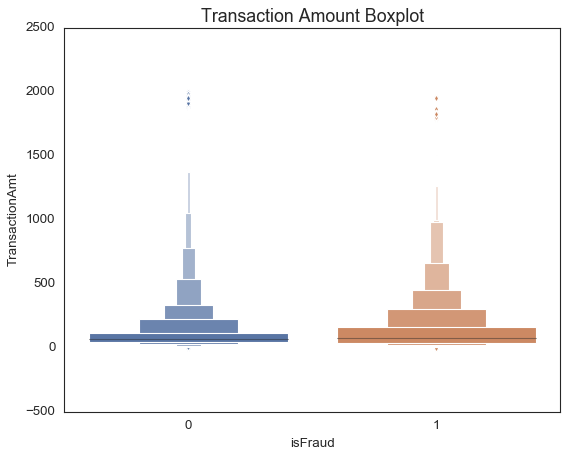

In [51]:
sns.boxenplot(x='isFraud', y='TransactionAmt', 
                  data=train[train['TransactionAmt'] <= 2000]).set_title("Transaction Amount Boxplot", fontsize=16)

In [52]:
CalcOutliers(df['TransactionAmt'])

Identified lowest outliers: 0
Identified upper outliers: 18323
Total outlier observations: 18323
Non-outlier observations: 1078908
Total percentual of Outliers:  1.6983


- Variance of TransactionAMT is quite large.
- Identify 18323 outliers with 3 times std away from mean. And the outliers' values are close to 2000. 
- Since the variance of amount distribution is large, apply log transformation to get rid of the affect extreme transaction amount.
### Visualize transaction amounts

Text(0.5, 0, 'TransactionAmt')

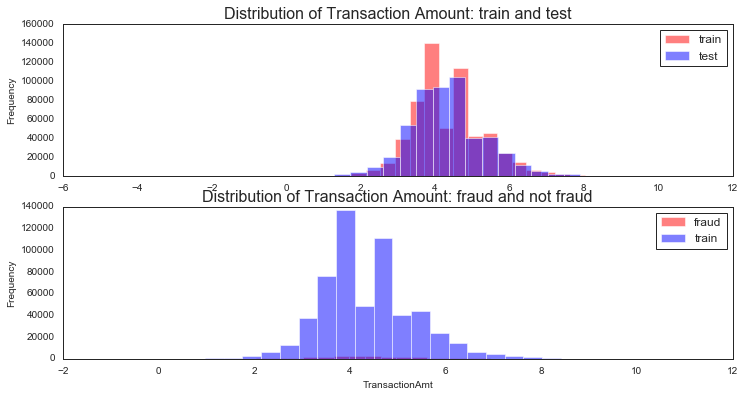

In [53]:
fig, axes = plt.subplots(2, 1, figsize=(12,6))
train['TransactionAmt'].apply(np.log).plot(kind='hist', label='train', color='red', 
                                           alpha=0.5, bins=30, ax=axes[0])
test['TransactionAmt'].apply(np.log).plot(kind='hist', label='test', color='blue', 
                                           alpha=0.5, bins=30, ax=axes[0])
train[train['isFraud'] == 1]['TransactionAmt'].apply(np.log).plot(kind='hist', label='fraud', color='red', 
                                           alpha=0.5, bins=30, ax=axes[1])
train[train['isFraud'] == 0]['TransactionAmt'].apply(np.log).plot(kind='hist', label='train', color='blue', 
                                           alpha=0.5, bins=30, ax=axes[1])
axes[0].legend()
axes[0].set_title('Distribution of Transaction Amount: train and test', fontsize=16)
axes[1].legend()
axes[1].set_title('Distribution of Transaction Amount: fraud and not fraud', fontsize=16)
axes[1].set_xlabel('TransactionAmt')

Take a closer look at the amount distribution of fraud and not fraud.

Text(0.5, 1.0, 'Distribution of Transaction Amount: not fraud')

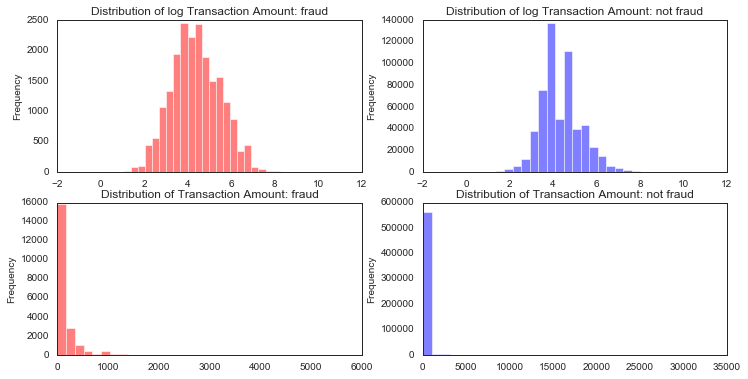

In [54]:
fig, axes = plt.subplots(2, 2, figsize=(12,6))
train[train['isFraud'] == 1]['TransactionAmt'].apply(np.log).plot(kind='hist', label='fraud', color='red', 
                                           alpha=0.5, bins=30, ax=axes[0,0], xlim=(-2,12))
train[train['isFraud'] == 0]['TransactionAmt'].apply(np.log).plot(kind='hist', label='train', color='blue', 
                                           alpha=0.5, bins=30, ax=axes[0,1])
train[train['isFraud'] == 1]['TransactionAmt'].plot(kind='hist', label='fraud', color='red', 
                                           alpha=0.5, bins=30, ax=axes[1,0])
train[train['isFraud'] == 0]['TransactionAmt'].plot(kind='hist', label='train', color='blue', 
                                           alpha=0.5, bins=30, ax=axes[1,1])

axes[0,0].set_title('Distribution of log Transaction Amount: fraud', fontsize=12)
axes[0,1].set_title('Distribution of log Transaction Amount: not fraud', fontsize=12)
axes[1,0].set_title('Distribution of Transaction Amount: fraud', fontsize=12)
axes[1,1].set_title('Distribution of Transaction Amount: not fraud', fontsize=12)

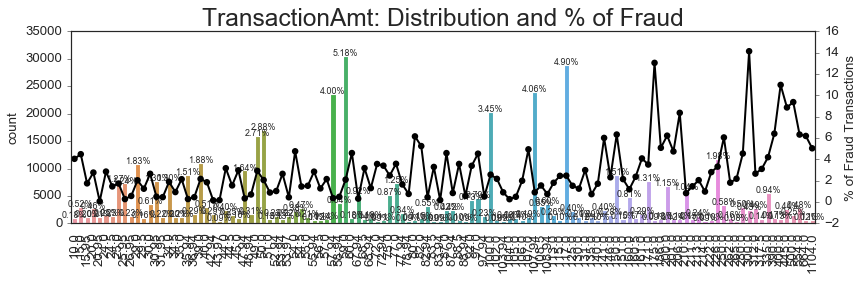

In [55]:
card_num_plot('TransactionAmt', is_hist, 500)

- The distributions of *TransactionAmt* for train and test are similar except the maxminum in test is much larger.
- Fraudulent charges appear to have more higher amount transaction.

### -- Address: addr1 & addr2

In [56]:
df.groupby('isFraud')[['addr1', 'addr2']].agg(['max','min', 'mean','median', 'std'])

addr1                                        addr2                   \
           max    min        mean median         std    max   min       mean   
isFraud                                                                        
0        540.0  100.0  290.643341  299.0  101.692564  102.0  13.0  86.813620   
1        536.0  110.0  294.317134  299.0  103.584955   96.0  10.0  86.286024   
99       540.0  100.0  291.846514  299.0  102.062730  102.0  10.0  86.723412   

                          
        median       std  
isFraud                   
0         87.0  2.607742  
1         87.0  4.936238  
99        87.0  2.987328

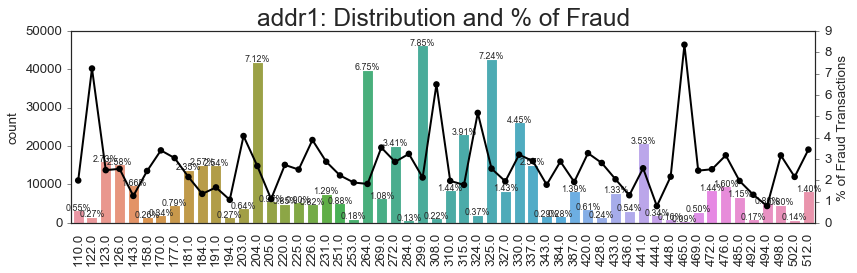

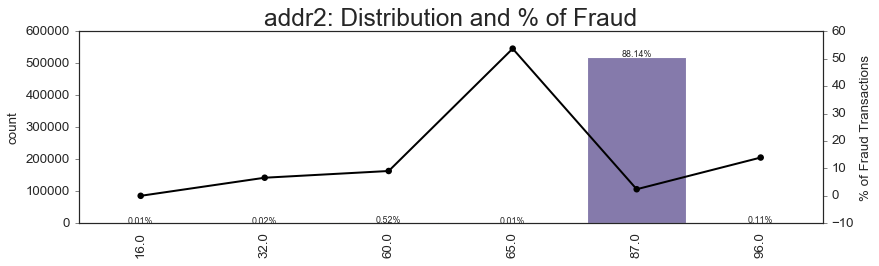

In [57]:
for col, is_hist, limit in [['addr1', 0, 500], ['addr2', 0, 50]]:
    card_num_plot(col, is_hist, limit)

- In *addr1*, 122, 308 and 465 have nearly 20% of fraud which is much higher than other values.
- In *addr2*, 87 is the most common value, making up 88.14% of the total counts.
- For value 65 in *addr2*, the fraction of fraudulent transactions is extreme high which is close to 60%. While its total frequency is only 0.01%.

### -- Distance: dist1 & dist2

In [58]:
df.groupby('isFraud')[['dist1', 'dist2']].agg(['max','min', 'mean','median', 'std'])

dist1                                        dist2       \
             max  min        mean median         std      max  min   
isFraud                                                              
0        10290.0  0.0  117.360193    8.0  370.643643  11624.0  0.0   
1         4944.0  0.0  174.592429   10.0  424.253985   9336.0  0.0   
99        8080.0  0.0   87.064862    8.0  314.126138   9220.0  0.0   

                                        
               mean median         std  
isFraud                                 
0        235.200643   36.0  536.806146  
1        201.472795   49.0  451.601987  
99       237.172741   44.0  556.436844

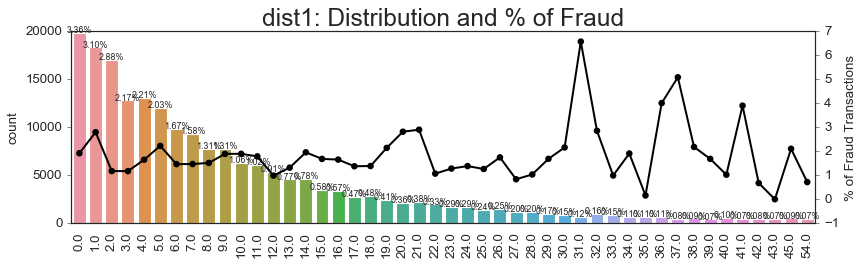

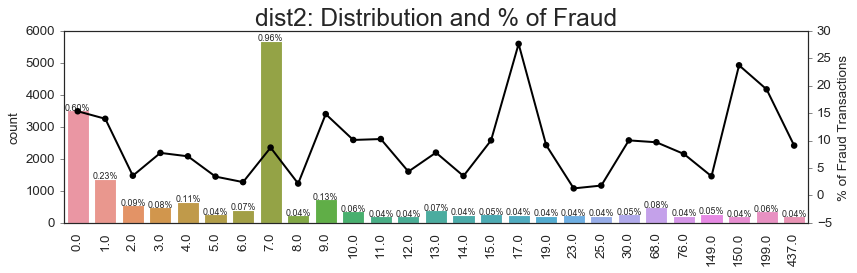

In [59]:
for col, is_hist, limit in [['dist1', 0, 400], ['dist2', 0, 200]]:
    card_num_plot(col, is_hist, limit)

### -- Emaildomain: Pemaildomain & Remaildomain

<Figure size 640x480 with 0 Axes>

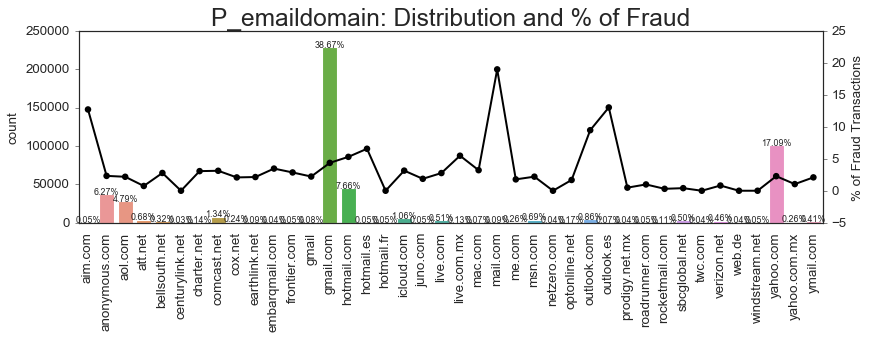

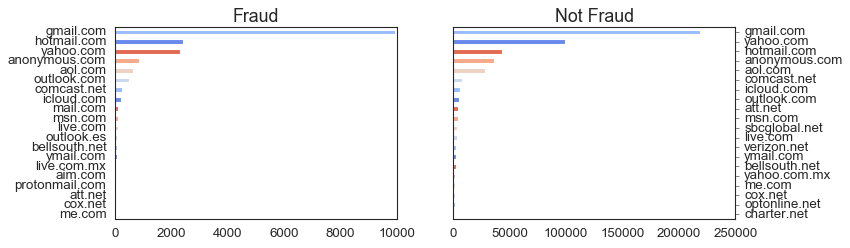

In [60]:
percent_hist_set('P_emaildomain', size=(10,3), n=20, limit=200, is_hist=0)

<Figure size 640x480 with 0 Axes>

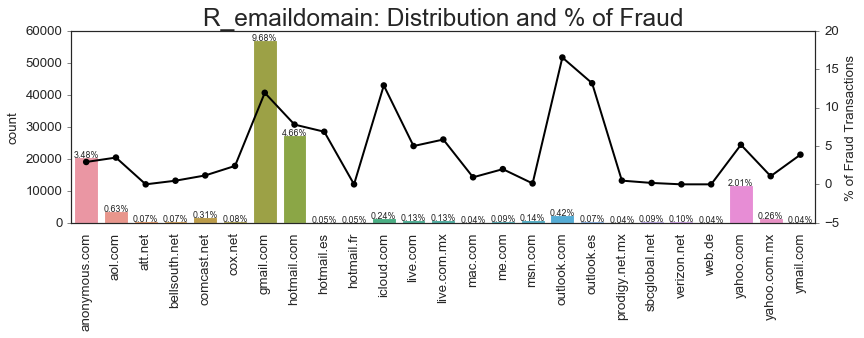

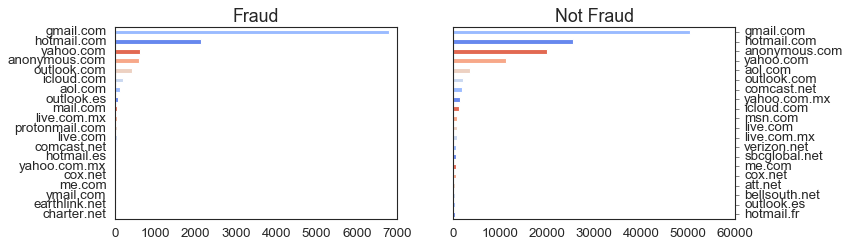

In [61]:
percent_hist_set('R_emaildomain', size=(10,3), n=20, limit=200, is_hist=0)

- Purchasers' email with domain aim.com, mail.com and outlook.es are more likely to be fraudulent.
- The number of hotmail.com outweigh yahoo.com in fraud transactions while for not fraud transactions, thing are the opposite.
- For receivers, outlook.com, icloud.com and gmail.com are top three possible to be fraudulent.

### -- Counting features: C1-C14

In [62]:
resumetable(df[['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8',
                      'C9', 'C10', 'C11', 'C12', 'C13', 'C14']])

Dataset Shape: (1097231, 14)


Name   dtypes  Missing  Uniques  First Value  Second Value  Third Value  \
0    C1  float64        3     1964          1.0           1.0          1.0   
1    C2  float64        3     1706          1.0           1.0          1.0   
2    C3  float64        3       32          0.0           0.0          0.0   
3    C4  float64        3     1495          0.0           0.0          0.0   
4    C5  float64        3      353          0.0           0.0          0.0   
5    C6  float64        3     1537          1.0           1.0          1.0   
6    C7  float64        3     1301          0.0           0.0          0.0   
7    C8  float64        3     1296          0.0           0.0          0.0   
8    C9  float64        3      360          1.0           0.0          1.0   
9   C10  float64        3     1278          0.0           0.0          0.0   
10  C11  float64        3     1677          2.0           1.0          1.0   
11  C12  float64        3     1373          0.0           0.0          0.0   
12  C13  float64     4748     1558          1.0           1.0          1.0   
13  C14  float64        3     1150          1.0           1.0          1.0   

    Entropy  
0      2.71  
1      2.76  
2      0.11  
3      1.17  
4      2.00  
5      2.50  
6      0.76  
7      1.30  
8      2.62  
9      1.31  
10     2.11  
11     1.10  
12     4.66  
13     2.61

In [63]:
df.groupby('isFraud')[['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8',
                      'C9', 'C10', 'C11', 'C12', 'C13', 'C14']].agg(['max','min', 'mean','median', 'std'])

C1                                         C2                  \
            max  min       mean median         std     max  min       mean   
isFraud                                                                      
0        4684.0  0.0  13.314894    1.0  127.786072  5692.0  0.0  14.173381   
1        4680.0  0.0  35.535450    2.0  242.970236  5690.0  0.0  45.509607   
99       2950.0  0.0  10.093241    1.0   79.335813  3276.0  0.0  10.714582   

                              C3                                      C4       \
        median         std   max  min      mean median       std     max  min   
isFraud                                                                         
0          1.0  147.488906  26.0  0.0  0.005840    0.0  0.153208  2252.0  0.0   
1          2.0  287.816365   1.0  0.0  0.000242    0.0  0.015554  2252.0  0.0   
99         1.0   88.895090  31.0  0.0  0.027403    0.0  0.227753  1601.0  0.0   

                                          C5                                   \
              mean median         std    max  min      mean median        std   
isFraud                                                                         
0         3.693878    0.0   65.839276  349.0  0.0  5.722537    0.0  26.121841   
1        15.077288    1.0  125.672919  331.0  0.0  1.406717    0.0  12.946092   
99        2.385875    0.0   41.942977  376.0  0.0  4.962701    0.0  25.462195   

             C6                                         C7                  \
            max  min       mean median         std     max  min       mean   
isFraud                                                                      
0        2252.0  0.0   8.786377    1.0   68.689196  2256.0  0.0   2.517475   
1        2252.0  0.0  16.923099    1.0  126.297945  2252.0  0.0  11.977351   
99       1601.0  0.0   6.854992    1.0   46.783565  1621.0  0.0   1.678173   

                                C8                                        C9  \
        median         std     max  min       mean median         std    max   
isFraud                                                                        
0          0.0   58.860454  3332.0  0.0   4.560875    0.0   91.022728  210.0   
1          0.0  115.146775  3328.0  0.0  21.242172    1.0  176.688736  192.0   
99         0.0   37.874827  1005.0  0.0   1.893994    0.0   26.766115  572.0   

                                             C10                         \
         min      mean median        std     max  min       mean median   
isFraud                                                                   
0        0.0  4.580904    1.0  16.889451  3256.0  0.0   4.723523    0.0   
1        0.0  1.703964    0.0   8.453280  3254.0  0.0  19.494072    1.0   
99       0.0  4.611943    1.0  21.282640   881.0  0.0   1.810149    0.0   

                        C11                                        C12       \
                std     max  min       mean median         std     max  min   
isFraud                                                                       
0         91.238802  3188.0  0.0   9.747849    1.0   90.307232  3188.0  0.0   
1        176.921325  3186.0  0.0  23.857523    2.0  170.967248  3186.0  0.0   
99        23.692393  2234.0  0.0   7.484636    1.0   61.323944  2234.0  0.0   

                                          C13                         \
              mean median         std     max  min       mean median   
isFraud                                                                
0         3.549727    0.0   82.601896  2918.0  0.0  32.814474    3.0   
1        18.597590    0.0  162.083532  2916.0  0.0  24.967720    1.0   
99        2.649528    0.0   53.974699  1562.0  0.0  27.816035    3.0   

                        C14                                    
                std     max  min       mean median        std  
isFraud                                                        
0        127.832113  1429.0  0.0   8.220491    1.0  47.898725  
1    

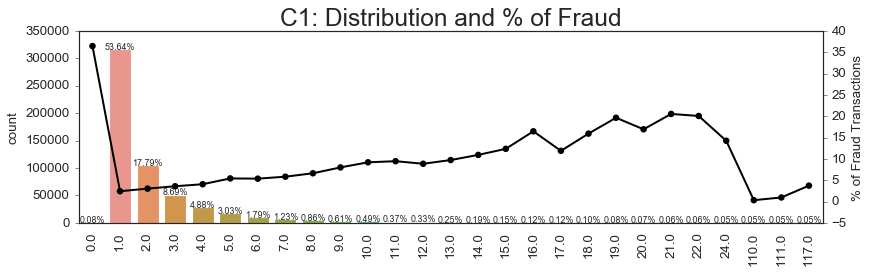

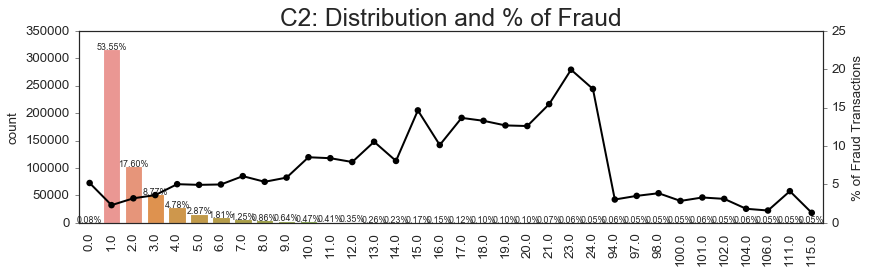

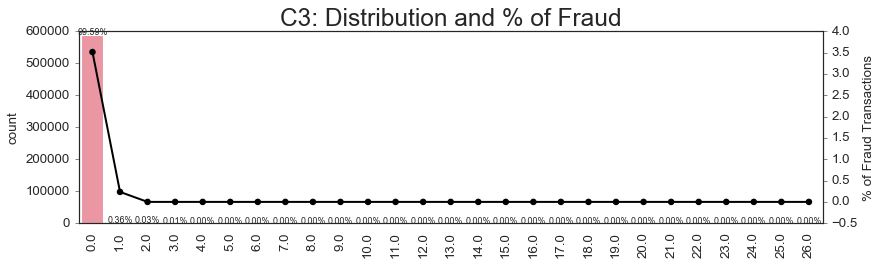

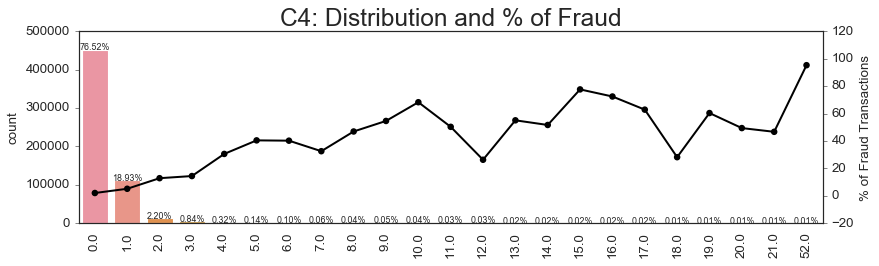

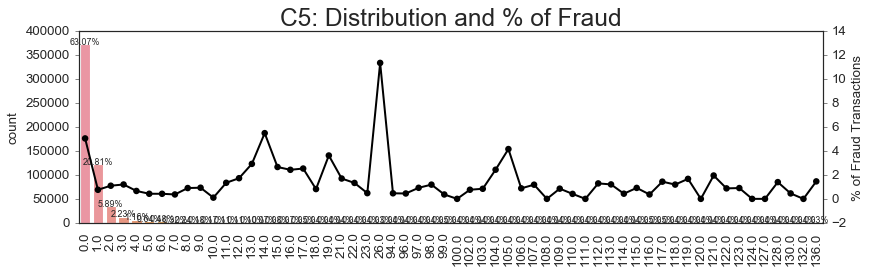

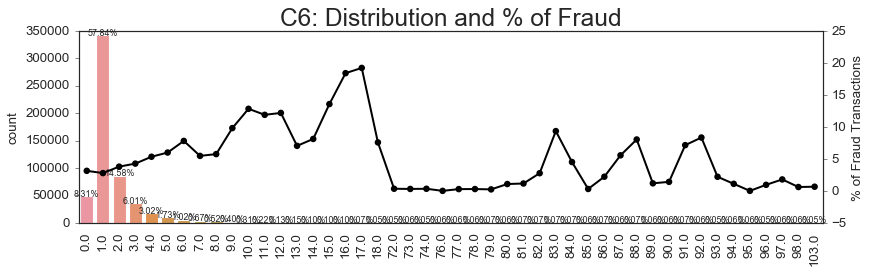

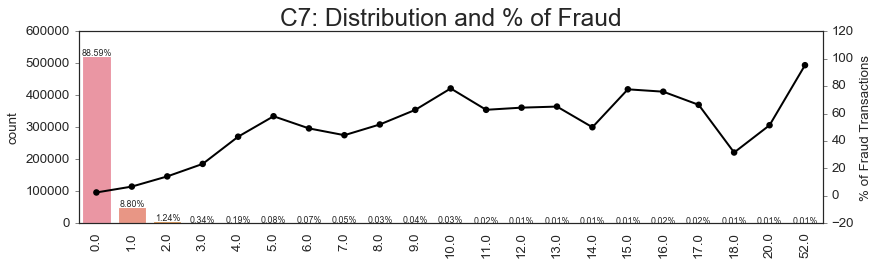

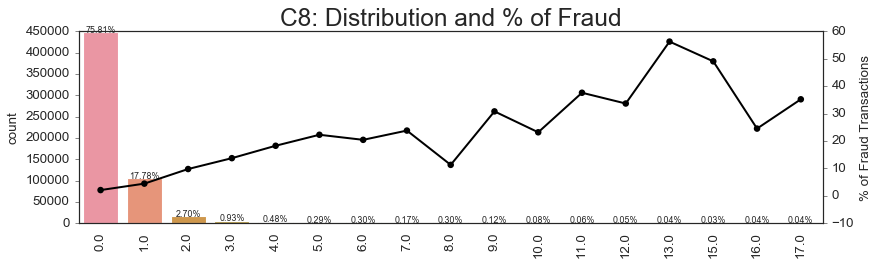

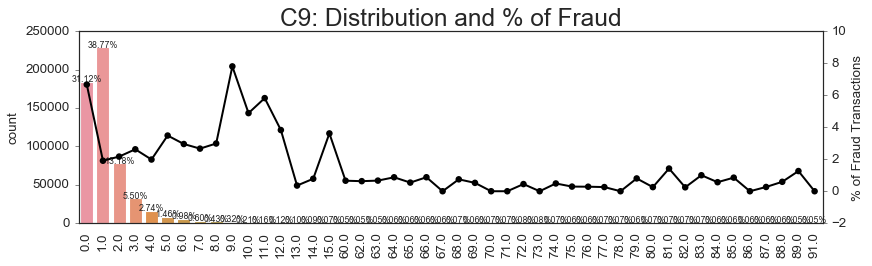

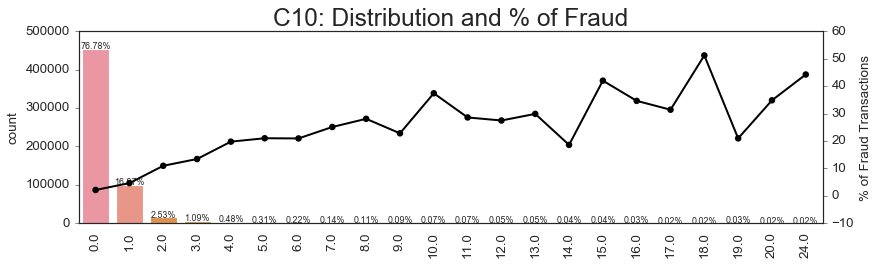

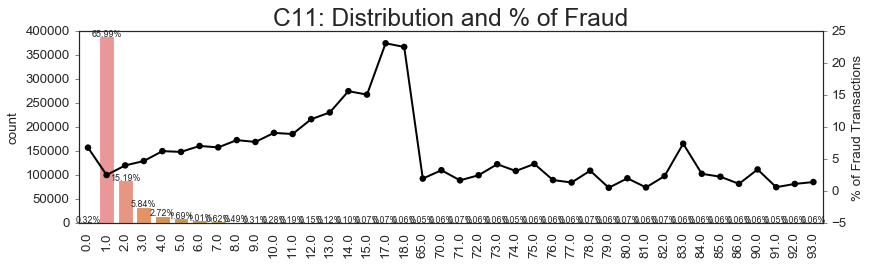

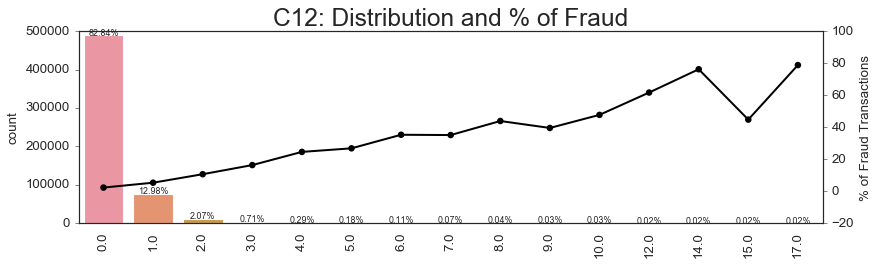

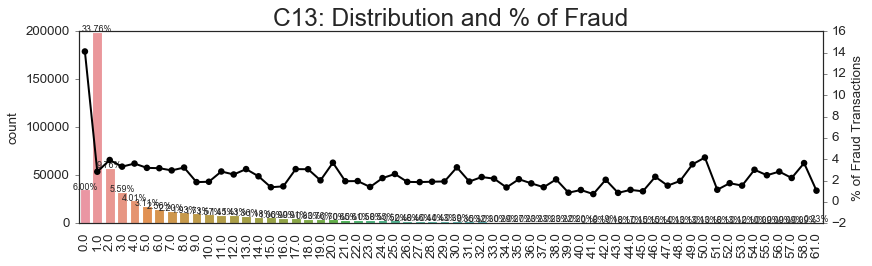

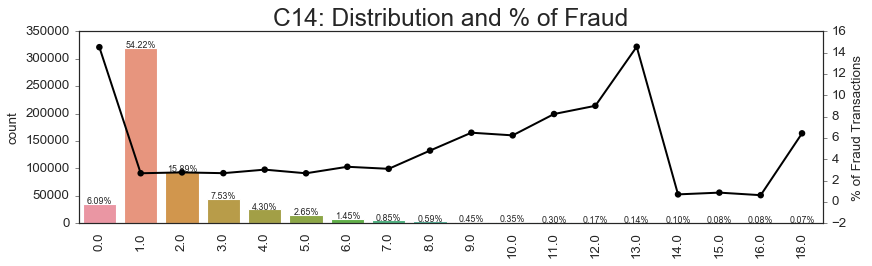

In [64]:
for col, is_hist, limit in [['C1', 0, 300], ['C2', 0, 300], ['C3', 0, 0], ['C4', 0, 50], ['C5', 0, 200],
                            ['C6', 0, 300], ['C7', 0, 50], ['C8', 0, 200], ['C9', 0, 300], ['C10', 0, 100], 
                            ['C11', 0, 300], ['C12', 0, 100], ['C13', 0, 500], ['C14', 0, 400]]:
    card_num_plot(col, is_hist, limit)

### -- Match features: M1-M9

In [65]:
resumetable(df[['M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9']])

Dataset Shape: (1097231, 9)


Name  dtypes  Missing  Uniques First Value Second Value Third Value  Entropy
0   M1  object   447739        2           T          NaN           T     0.00
1   M2  object   447739        2           T          NaN           T     0.45
2   M3  object   447739        2           T          NaN           T     0.73
3   M4  object   519189        3          M2           M0          M0     1.34
4   M5  object   660114        2           F            T           F     0.99
5   M6  object   328299        2           T            T           F     0.99
6   M7  object   581283        2         NaN          NaN           F     0.58
7   M8  object   581256        2         NaN          NaN           F     0.95
8   M9  object   581256        2         NaN          NaN           F     0.59

Too many missing values.

In [66]:
for col in ['M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9']:
    train[col] = train[col].fillna("Missing")

/Users/wangxinquan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


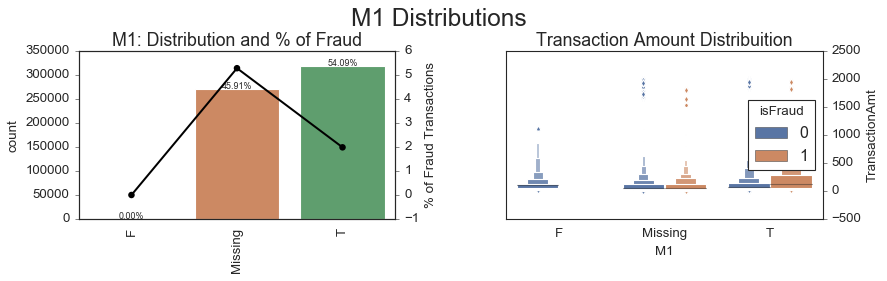

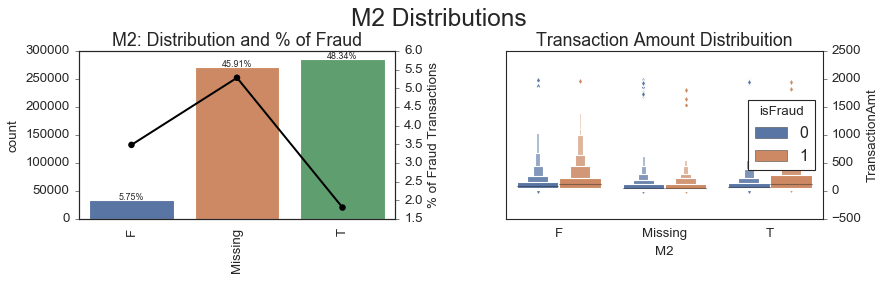

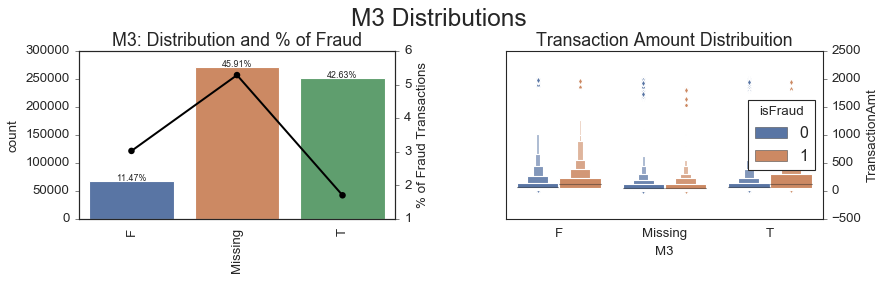

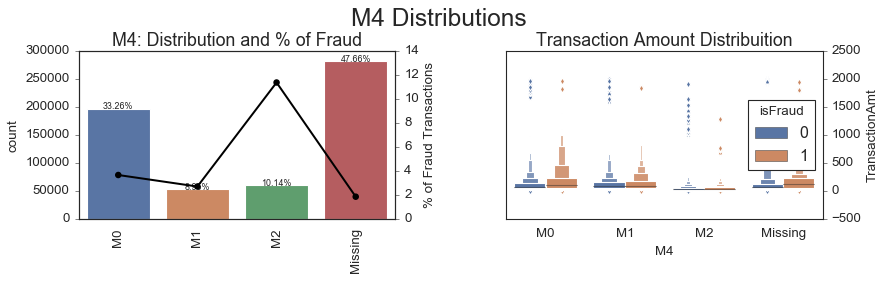

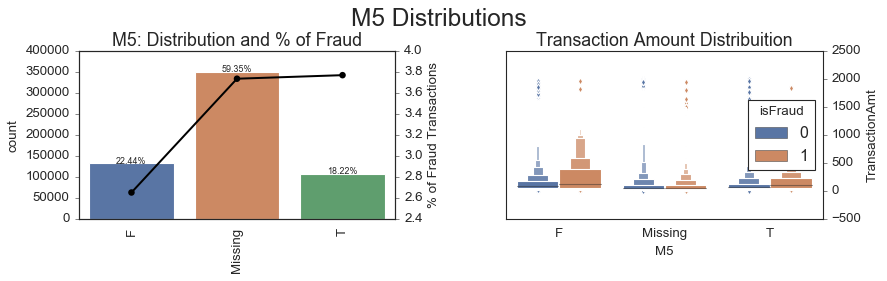

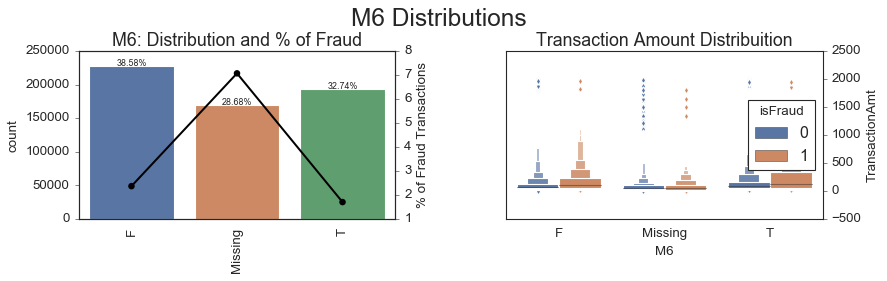

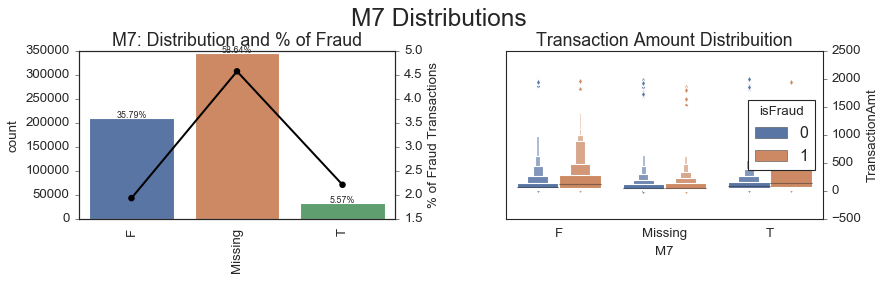

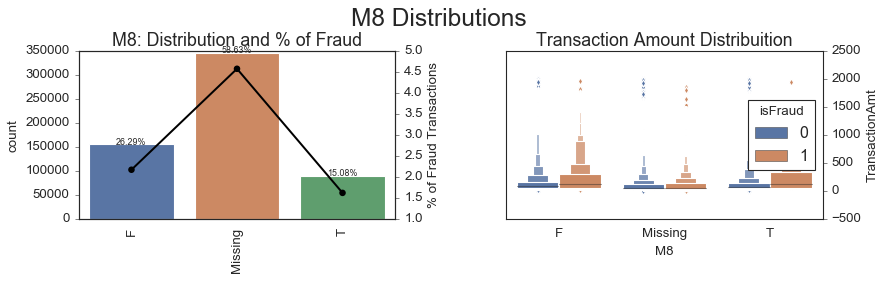

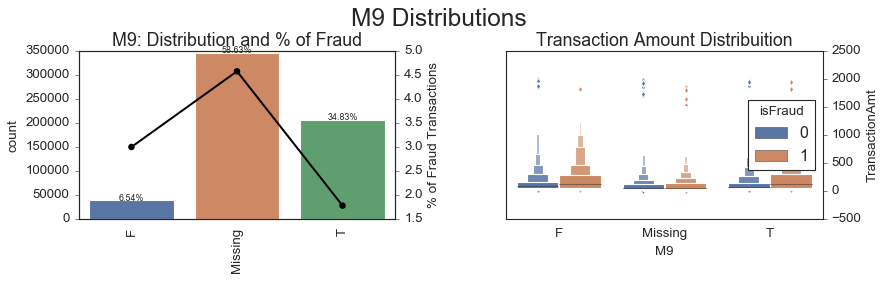

In [67]:
for col, is_hist, limit in [['M1', 0, 0], ['M2', 0, 0], ['M3', 0, 0], ['M4', 0, 0], ['M5', 0, 0],
                            ['M6', 0, 0], ['M7', 0, 0], ['M8', 0, 0], ['M9', 0, 0]]:
    percent_box_set(col, is_hist, limit)

- Except for *M4* and *M5*, group with missing values seem to have higher percentual to be fradulent.

## Identity features

- id_01-id_38
- DeviceType
- DeviceInfo

### -- Identity info: id_01-id_11

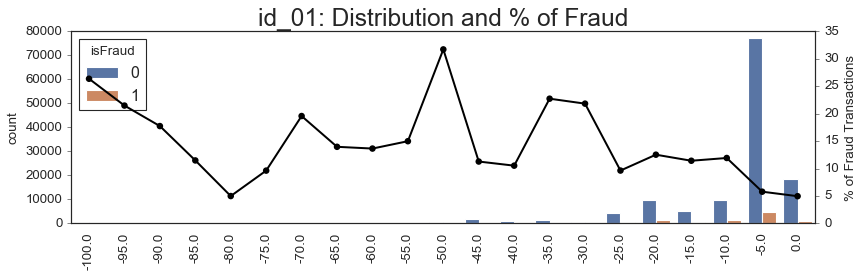

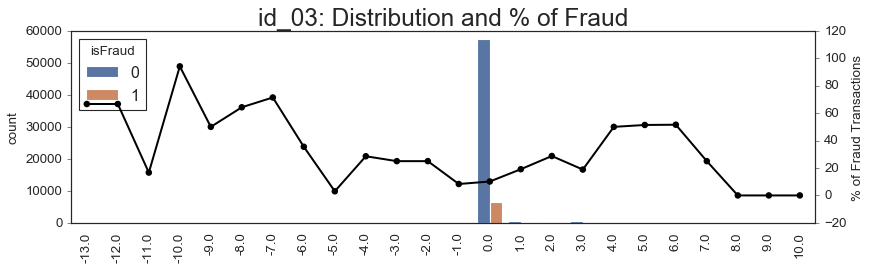

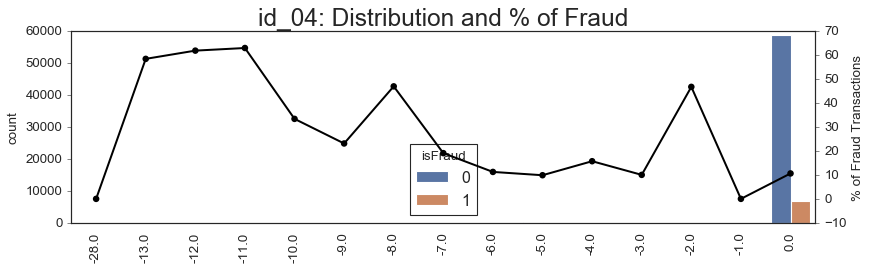

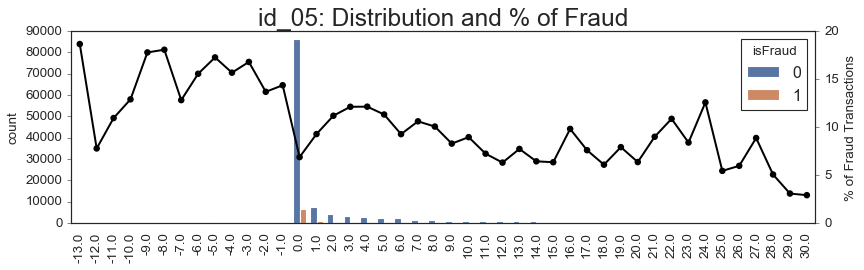

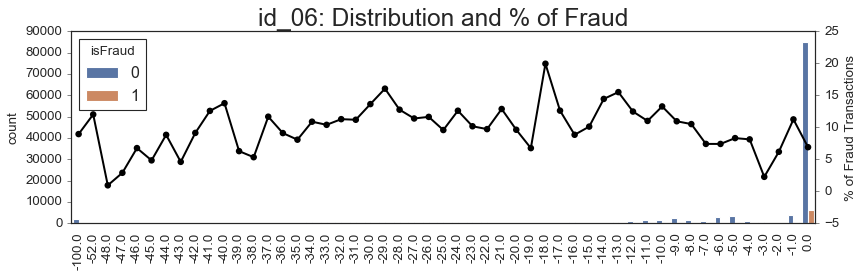

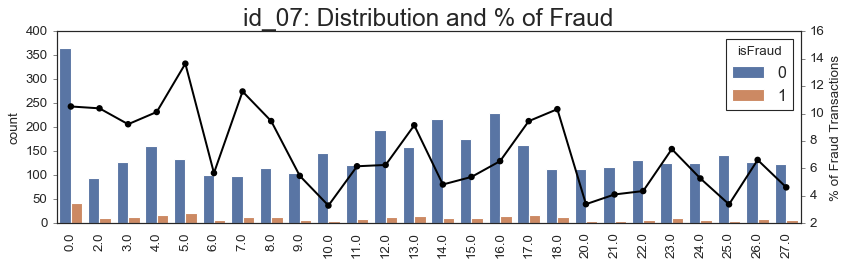

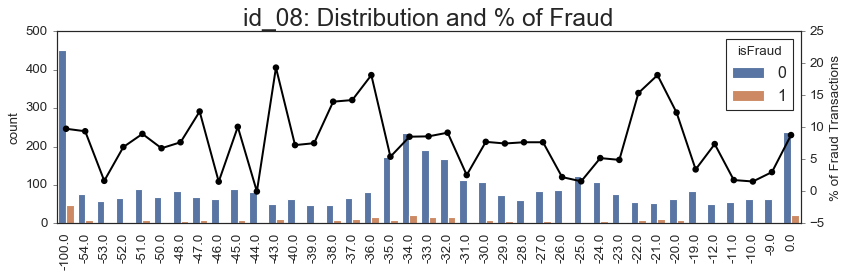

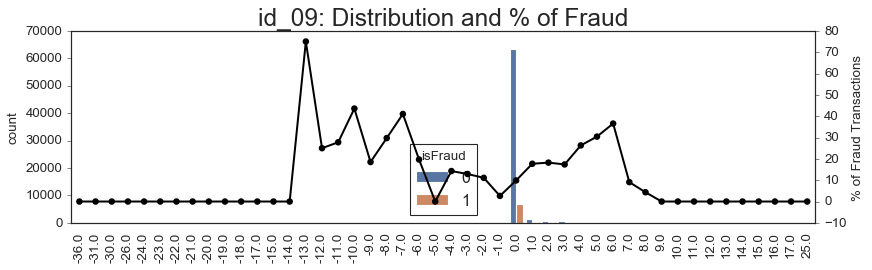

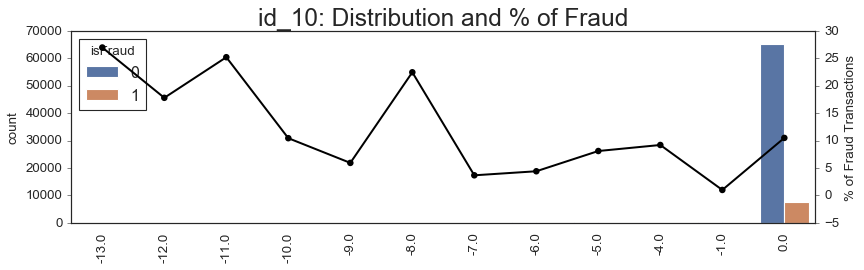

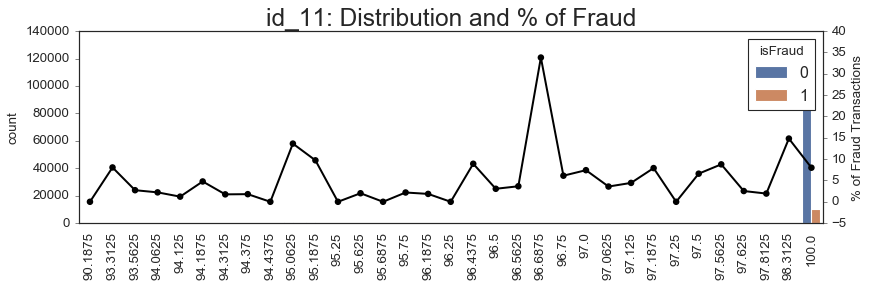

In [57]:
for col, is_hist, limit in [['id_01', 1, 50], ['id_03', 1, 0], ['id_04', 1, 0], ['id_05', 1, 100], 
                            ['id_06', 1, 100], ['id_07', 1, 100], ['id_08', 1, 50], 
                            ['id_09', 1, 0], ['id_10', 1, 50], ['id_11', 1, 50]]:
    card_num_plot_isFraud(col, is_hist, limit)

### -- Identity info: id_12-id_38

- id_12, id_15, id_16, id_23, id_27--id_29, id_34--id_38 are categoricals.

In [69]:
resumetable(df[['id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18',
       'id_19', 'id_20', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25',
       'id_26', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_32',
       'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38']])

Dataset Shape: (1097231, 27)


Name   dtypes  Missing  Uniques First Value Second Value Third Value  \
0   id_12   object   811091        2         NaN          NaN         NaN   
1   id_13  float64   839625       55         NaN          NaN         NaN   
2   id_14  float64   945830       28         NaN          NaN         NaN   
3   id_15   object   819269        3         NaN          NaN         NaN   
4   id_16   object   842144        2         NaN          NaN         NaN   
5   id_17  float64   821896      127         NaN          NaN         NaN   
6   id_18  float64  1001243       19         NaN          NaN         NaN   
7   id_19  float64   822007      568         NaN          NaN         NaN   
8   id_20  float64   822337      547         NaN          NaN         NaN   
9   id_21  float64  1087013      734         NaN          NaN         NaN   
10  id_22  float64  1087000       35         NaN          NaN         NaN   
11  id_23   object  1087000        3         NaN          NaN         NaN   
12  id_24  float64  1087744       17         NaN          NaN         NaN   
13  id_25  float64  1087060      440         NaN          NaN         NaN   
14  id_26  float64  1087021      115         NaN          NaN         NaN   
15  id_27   object  1087000        2         NaN          NaN         NaN   
16  id_28   object   819475        2         NaN          NaN         NaN   
17  id_29   object   819475        2         NaN          NaN         NaN   
18  id_30   object   949007       87         NaN          NaN         NaN   
19  id_31   object   820324      172         NaN          NaN         NaN   
20  id_32  float64   948974        6         NaN          NaN         NaN   
21  id_33   object   953271      461         NaN          NaN         NaN   
22  id_34   object   947251        4         NaN          NaN         NaN   
23  id_35   object   819269        2         NaN          NaN         NaN   
24  id_36   object   819269        2         NaN          NaN         NaN   
25  id_37   object   819269        2         NaN          NaN         NaN   
26  id_38   object   819269        2         NaN          NaN         NaN   

    Entropy  
0      0.60  
1      2.44  
2      1.80  
3      1.33  
4      1.00  
5      1.30  
6      1.80  
7      5.47  
8      5.48  
9      5.05  
10     0.55  
11     1.15  
12     1.51  
13     4.36  
14     4.45  
15     0.02  
16     0.99  
17     1.00  
18     4.45  
19     5.49  
20     0.89  
21     4.48  
22     0.54  
23     1.00  
24     0.23  
25     0.77  
26     0.97

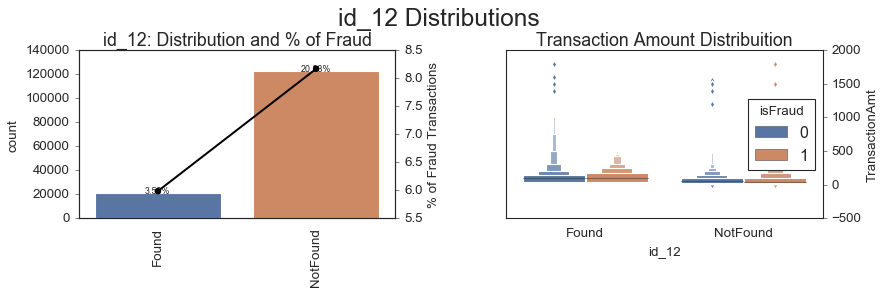

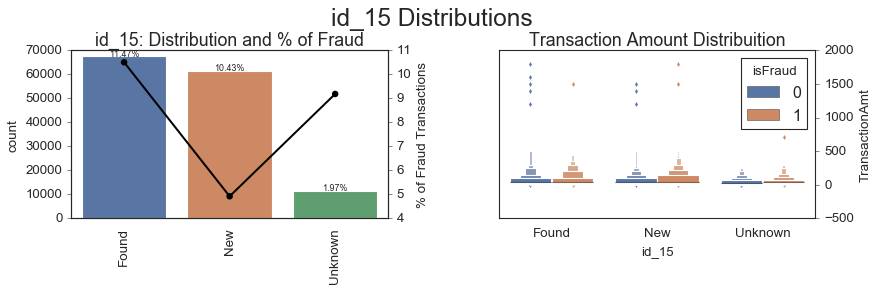

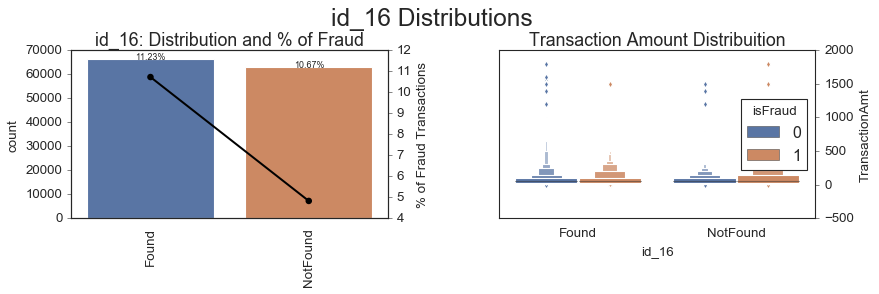

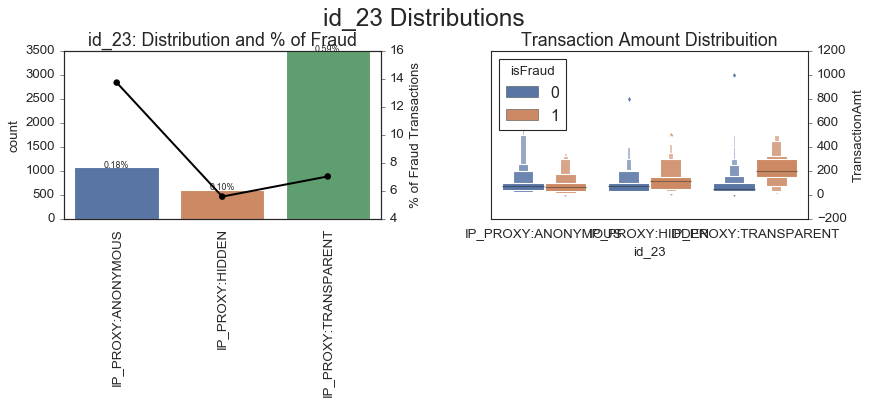

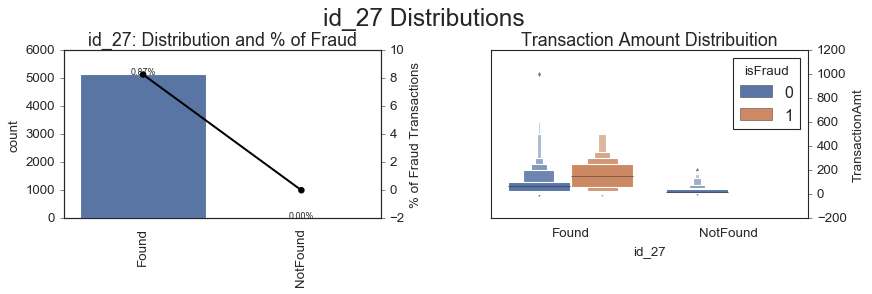

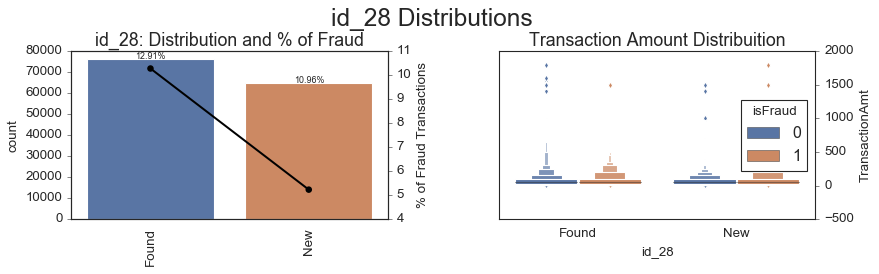

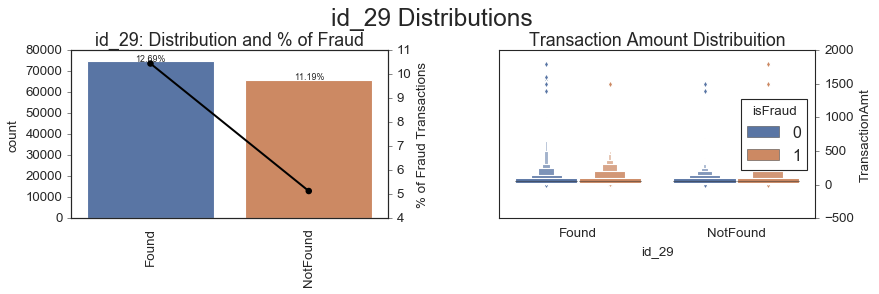

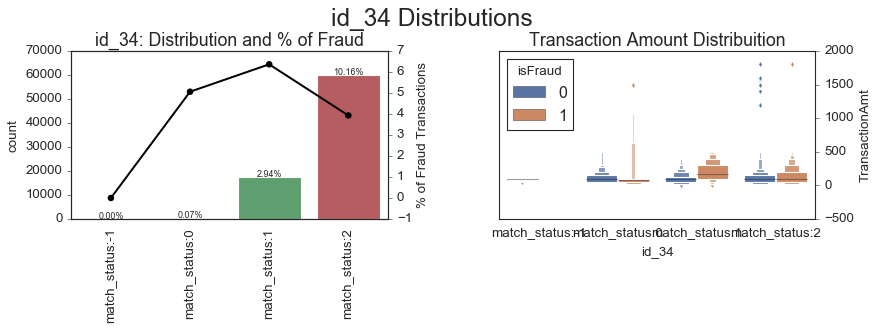

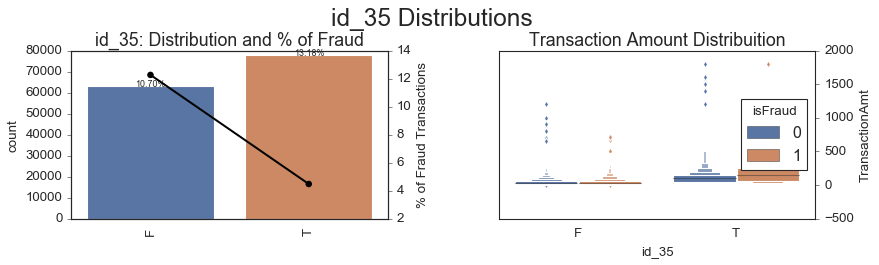

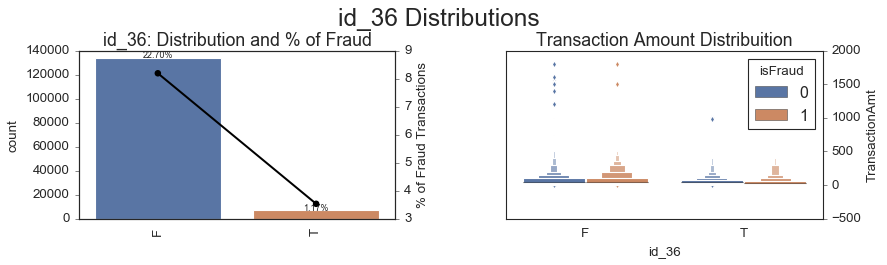

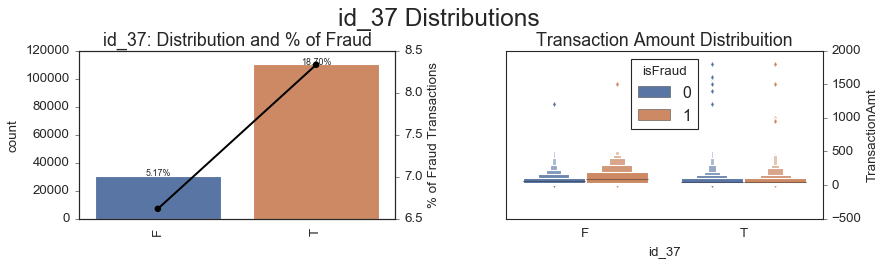

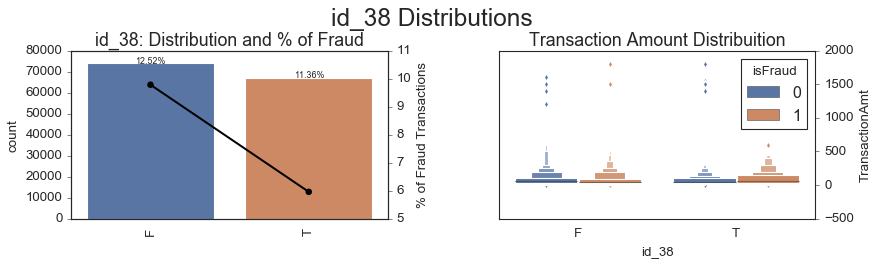

In [70]:
for col, is_hist, limit in [['id_12', 0, 0], ['id_15', 0, 0], ['id_16', 0, 0], ['id_23', 0, 0], ['id_27', 0, 0],
                            ['id_28', 0, 0], ['id_29', 0, 0], ['id_34', 0, 0], ['id_35', 0, 0], ['id_36', 0, 0], 
                            ['id_37', 0, 0], ['id_38', 0, 0]]:
    percent_box_set(col, is_hist, limit)

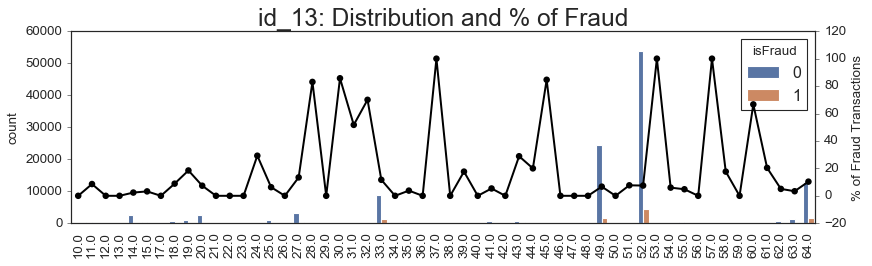

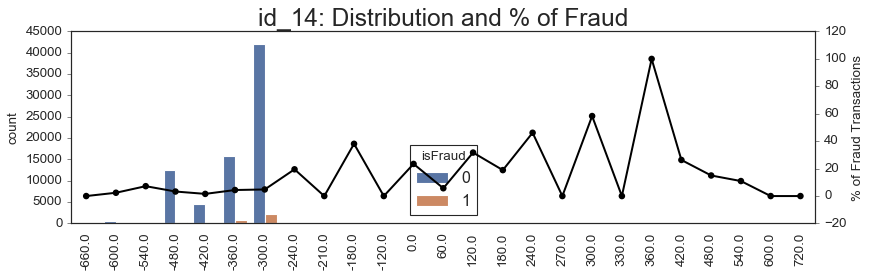

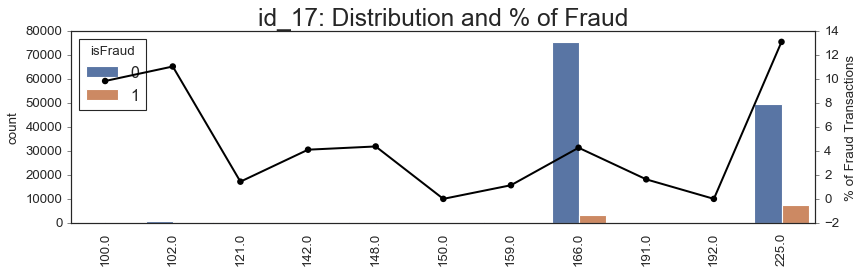

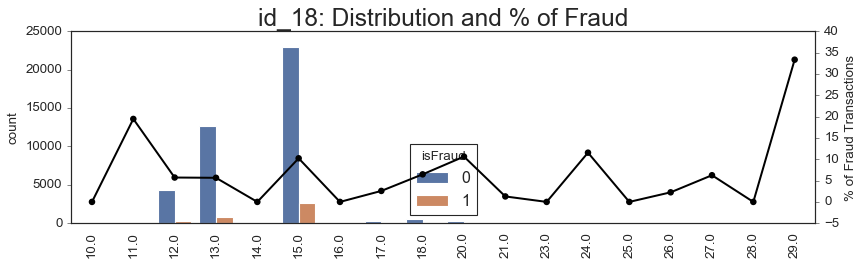

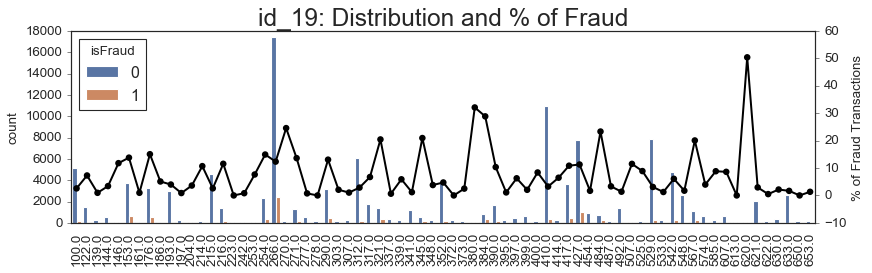

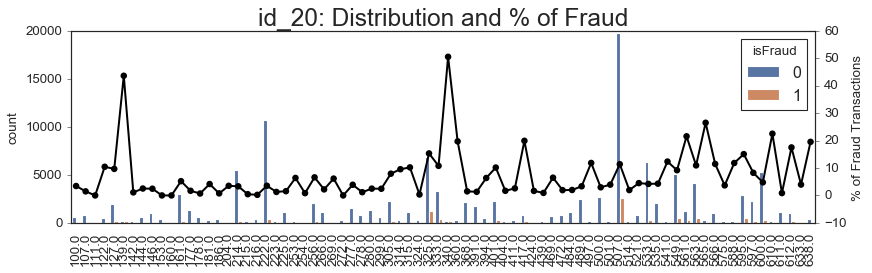

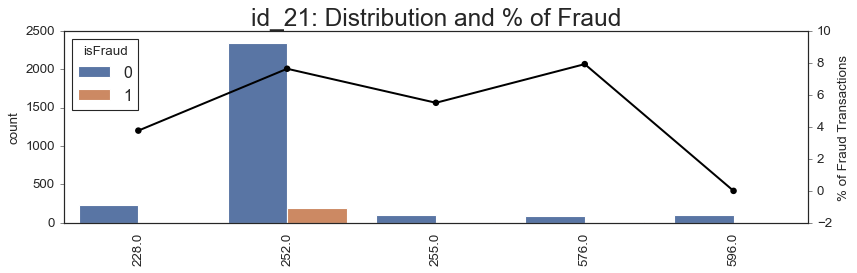

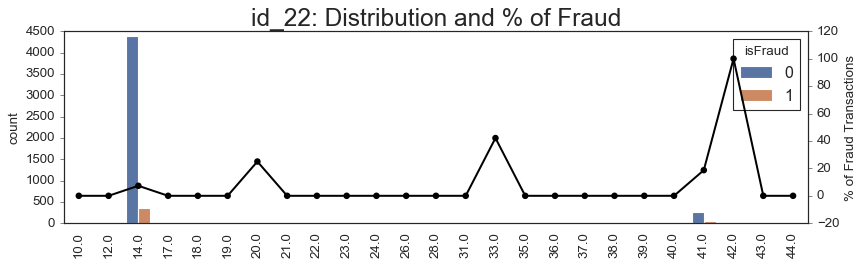

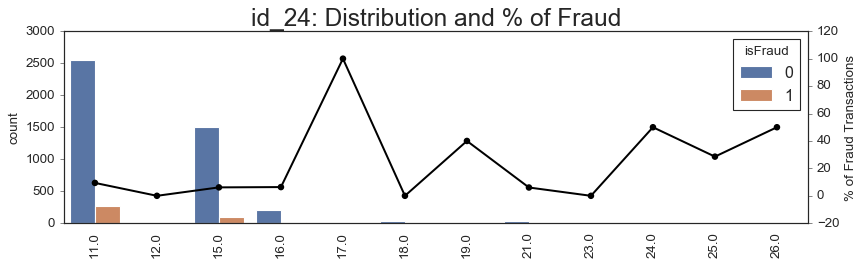

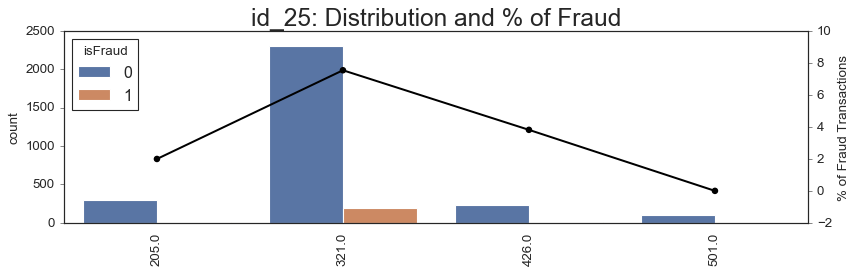

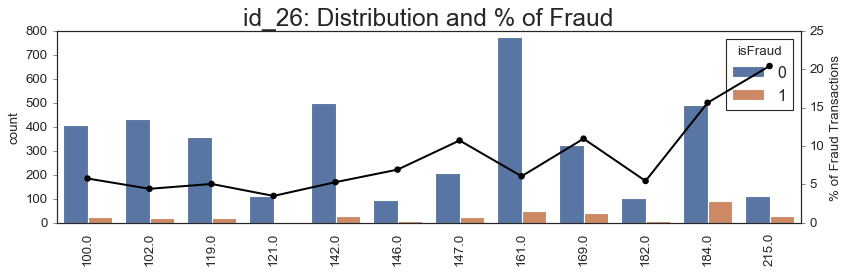

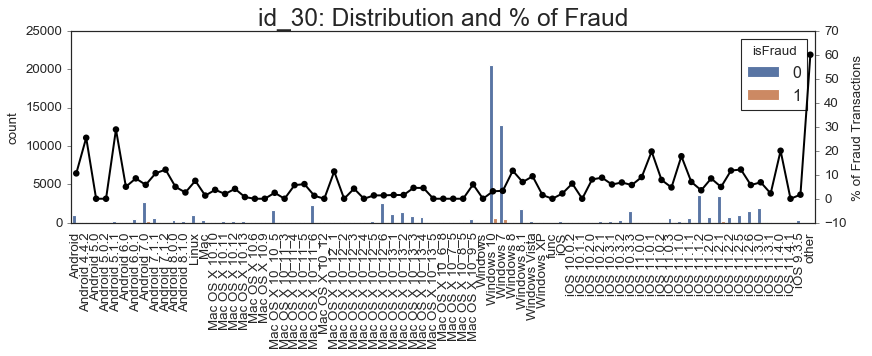

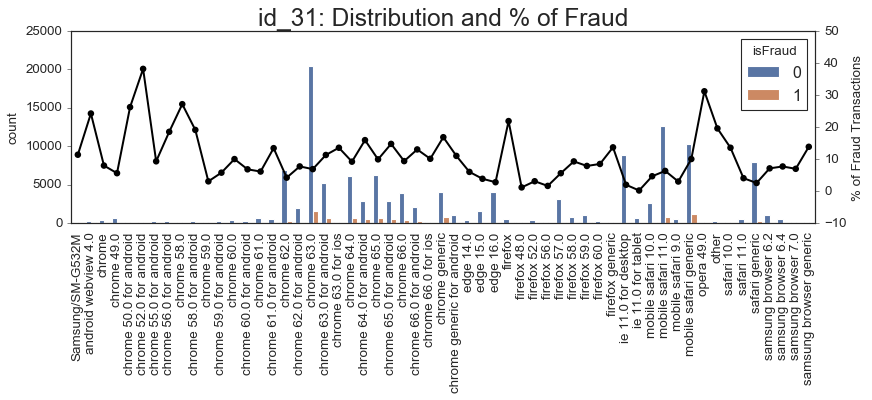

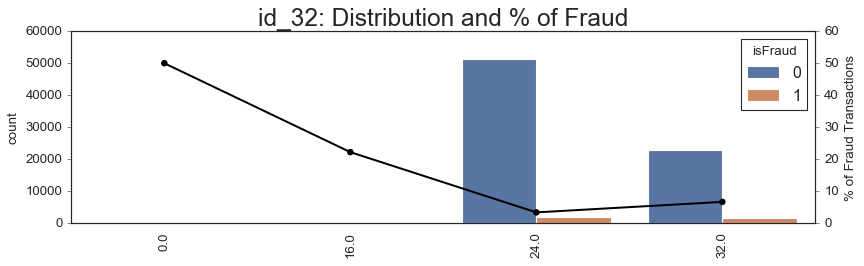

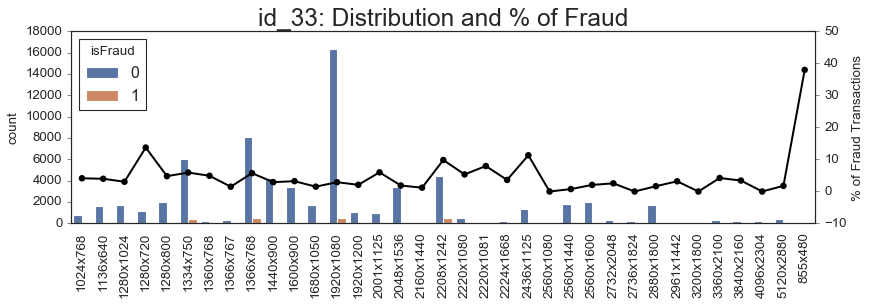

In [71]:
for col, is_hist, limit in [['id_13', 0, 0], ['id_14', 0, 0], ['id_17', 0, 100], ['id_18', 0, 0], ['id_19', 0, 100],
                            ['id_20', 0, 100], ['id_21', 0, 100], ['id_22', 0, 0], ['id_24', 0, 0], ['id_25', 0, 100], 
                            ['id_26', 0, 100], ['id_30', 0, 0], ['id_31', 0, 100], ['id_32', 0, 0], ['id_33', 0, 100]]:
    card_num_plot_isFraud(col, is_hist, limit)

### -- DeviceType

In [72]:
groupby_cnt_ratio(df, 'DeviceType')

count  count_ratio
is_train isFraud DeviceType                    
0                desktop     74403     0.543361
                 mobile      62528     0.456639
1        0       desktop     79611     0.614287
                 mobile      49988     0.385713
         1       desktop      5554     0.495406
                 mobile       5657     0.504594

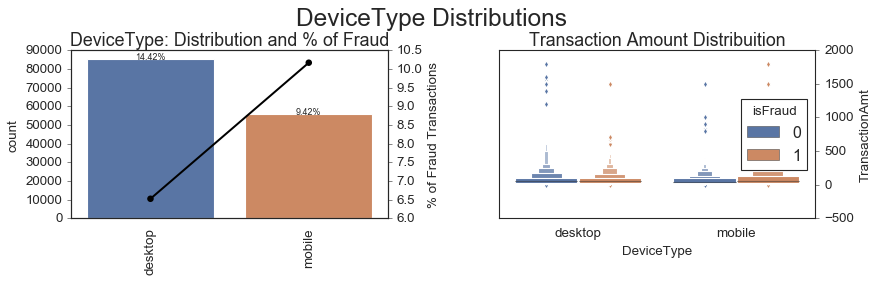

In [73]:
percent_box_set('DeviceType', 0, 0)

- Fraudulent transactions are made on mobile more than on desktop.
- Mobile transaction seems to be less secure than desktop.

### -- DeviceInfo

<Figure size 640x480 with 0 Axes>

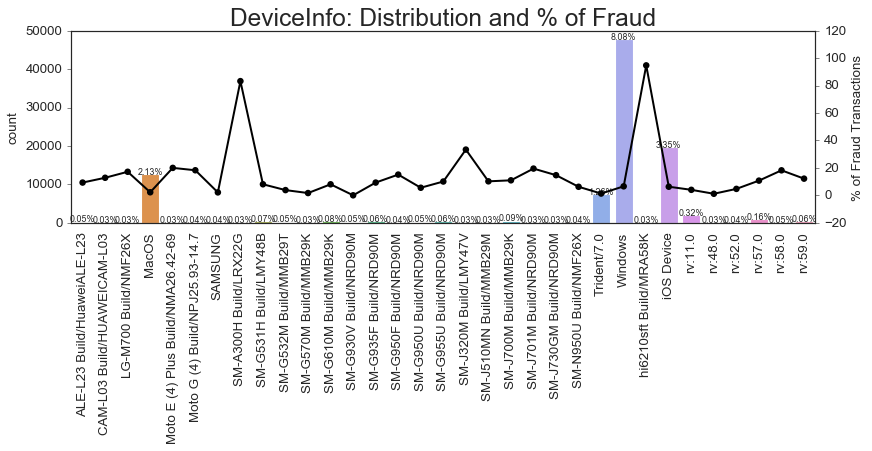

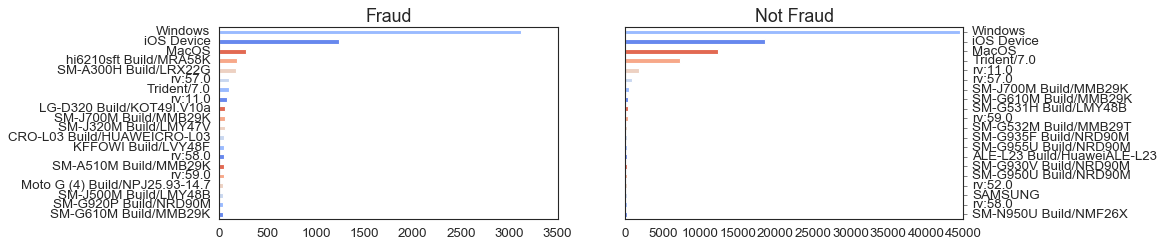

In [74]:
percent_hist_set('DeviceInfo', (12,3), 20, 150, 0)

- Despite for the top 3 device which is prevalent among all groups, hi6210sft Build/MRA58K and SM-A300H Build/LRX22G seem to be abnormal. They rank pretty high in fraud transaction records while they even don't appear in the non-fraud group's ranking. 
- Device info may be a good inference for fraud detection.

## Time features
- TransactionDT

In [75]:
import datetime

START_DATE = '2017-12-01'
startdate = datetime.datetime.strptime(START_DATE, "%Y-%m-%d")
df["Date"] = df['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds=x)))
df['YearMonth'] = df['Date'].map(lambda x: str(x.year) + str('-') + str(x.month))
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Weekday'] = df['Date'].dt.dayofweek
df['Day'] = df['Date'].dt.day
df['Hour'] = df['Date'].dt.hour

In [76]:
df.to_csv('./Data/processed_data.csv')

### Train and test

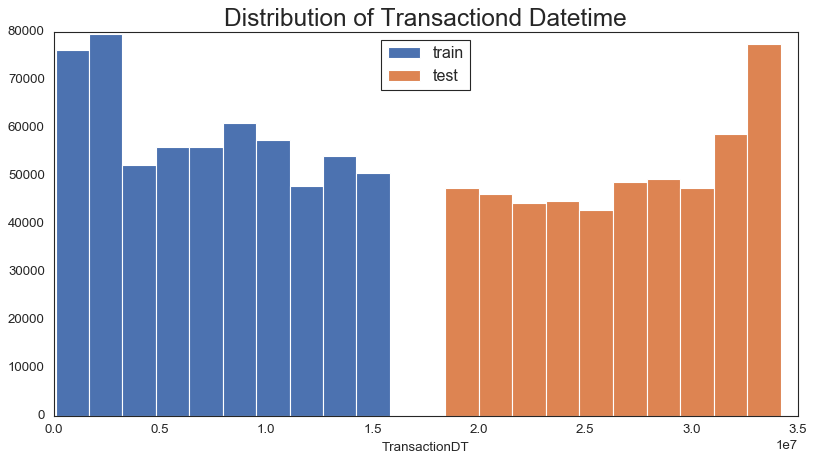

In [77]:
plt.figure(figsize=(12,6))
plt.hist(train['TransactionDT'], label='train')
plt.hist(test['TransactionDT'], label='test')
plt.title('Distribution of Transactiond Datetime', fontsize=22)
plt.xlabel('TransactionDT')
plt.legend(loc='best')

The transaction datetimes for train and test are not overlapping. And they seem to be split by time where train data is from a earlier datatime while test data is from later time. Anf there's a gap in time between train and test. Therefore cross validation method should be carefully used considering this situation.

### Time pattern

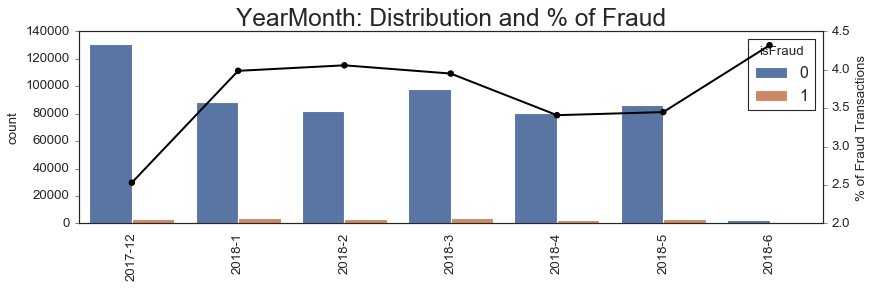

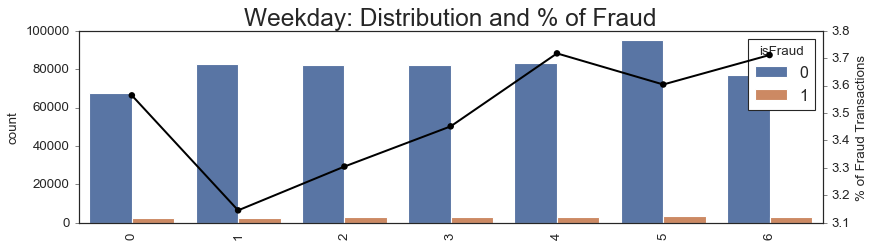

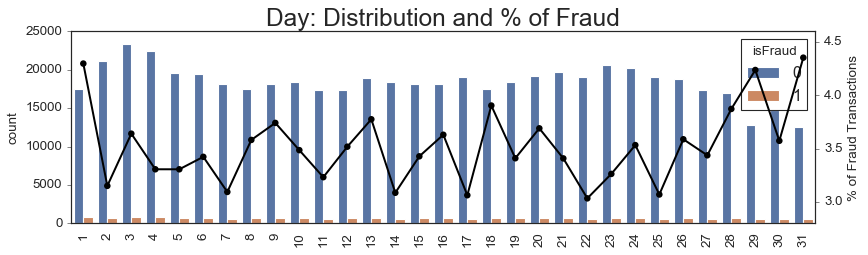

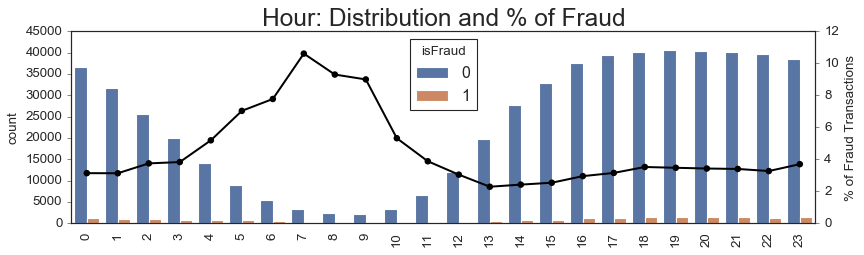

In [78]:
for col, is_hist, limit in [['YearMonth', 0, 0], ['Weekday', 0, 0], ['Day', 0, 0], ['Hour', 0, 0]]:
    card_num_plot_isFraud(col, is_hist, limit)

- The percentual of fraud transactions are stay high during the first quarter of the year. And June has the highest percentual while December ranks the lowest.
- Fraudulent transactions are more possible to happen on Thursday, Friday and Saturday.
- Interestingly to find that days are close to the end and start of a month have higher fraud rate. 
- Fraudulent transactions are mostly occurs at early of the day like 7--9.

# Reference
- https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
- https://www.kaggle.com/kabure/extensive-eda-and-modeling-xgb-hyperopt#kln-37